# Machine Learning con Applicazioni - Progetto

We consider the following dataset, which contains oceanographic data from Southern California: [CalCOFI Kaggle dataset](https://www.kaggle.com/datasets/sohier/calcofi). The goal is to implement a regression algorithm with regularization (Ridge or LASSO) and a Mercer kernel.
The dataset contains a large number of feature variables. It is necessary to select those representing the chemical-physical conditions of the ecosystem (e.g., temperature, salinity, depth, concentrations of chemical elements). 
The objective of this project is to predict **salinity** and **temperature** as functions of the other variables and/or to study correlations between the two.
Further information can be found on the [official CalCOFI website](https://calcofi.org/data/oceanographic-data/bottle-database/).


In [1]:
# importing relevant libraries
from math import isnan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colors

# sklearn
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.kernel_approximation import Nystroem
from sklearn.multioutput import MultiOutputRegressor

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline





import Functions
from Functions import *
# import style setups
plt.style.use('my_scientific_style.mplstyle')


# California Cooperative Oceanic Fisheries Investigations

The CalCOFI dataset represents the longest-running (from 1949 to the present) and most comprehensive (with over 50,000 sampling stations) oceanographic time series worldwide, including data on larval fish.
For the purposes of this project, we will focus on data related to the chemical-physical conditions of the system.
The data were collected at regular time intervals, allowing for the documentation of climatic cycles in the California currents. Notably, CalCOFI research brought global attention to the biological response to a dramatic Pacific warming event in 1957–58. Following these studies, the term “El Niño” was introduced into the scientific literature.
The data collected down to depths of 500 meters include: temperature, salinity, dissolved oxygen, phosphate, silicate, nitrate and nitrite, chlorophyll, transmissometer readings, PAR (photosynthetically active radiation), primary productivity measured via C14, phytoplankton biodiversity, zooplankton biomass, and zooplankton biodiversity.

Data collection is performed using sampling devices called CTD rosettes, which allow water samples to be collected from great depths. A photo of the instrument immersed in water is attached.

In [2]:
# import image module
from IPython.display import Image
# get the image
Image(url='https://calcofi.org/wp-content/uploads/2020/03/1904RL_sta93-50_CTDSurface-2048x1540.jpg', width=400, height=100)

For each expedition:
- Seawater samples are collected using 10-liter Niskin bottles attached to a 24-sample CTD rosette; 
- The samples are analyzed; 
- The data are recorded in the Bottle Database. The Bottle Database covers the entire time series—from 1949, the year the CalCOFI program began, up to the present.
Additional data are collected for each CTD to complete the characterization of the analyses.

## Descrizione del dataset

The CalCOFI dataset represents the longest-running (from 1949 to the present) and most comprehensive (with over 50,000 sampling stations) oceanographic time series worldwide, including data on larval fish.  
For the purposes of this project, we will focus on data related to the chemical-physical conditions of the system.

The data were collected at regular time intervals, allowing for the documentation of climatic cycles in the California currents. Notably, CalCOFI research brought global attention to the biological response to a dramatic Pacific warming event in 1957–58. Following these studies, the term “El Niño” was introduced into the scientific literature.

The data collected down to depths of 500 meters include: temperature, salinity, dissolved oxygen, phosphate, silicate, nitrate and nitrite, chlorophyll, transmissometer readings, PAR (photosynthetically active radiation), primary productivity measured via C14, phytoplankton biodiversity, zooplankton biomass, and zooplankton biodiversity.

Data collection is performed using sampling devices called **CTD rosettes**, which allow water samples to be collected from great depths.  

For each expedition:  
- Seawater samples are collected using 10-liter Niskin bottles attached to a 24-sample CTD rosette.  
- The samples are analyzed.  
- The data are recorded in the **Bottle Database**, which covers the entire time series—from 1949, the year the CalCOFI program began, up to the present.  

Additional data are collected for each CTD to complete the characterization of the analyses.

The downloaded file contains two main datasets:

- **Cast.csv**: contains metadata for each CTD cast. This dataset includes information on date, time, latitude, longitude, weather conditions, and other details for each cast performed during a CalCOFI cruise. Each row represents a unique cast, numbered sequentially and indexed by the column `Cst_Cnt`.

- **Bottle.csv**: contains oceanographic data. This database includes oceanographic measurements taken for each bottle/depth sampled during the CalCOFI cruises. Additional columns report codes and data precision, which are useful for assessing measurement quality. Each row represents a single bottle or sampled depth, numbered sequentially and indexed by the column `Btl_Cnt`.

The column `Cst_Cnt` in the Bottle table can be used as a key to merge the two datasets.


At this [link](https://calcofi.org/data/oceanographic-data/bottle-database/), metadata can be downloaded to decode the meaning of each column in the initial dataset and to interpret the codes related to data quality.

The dataset is complex, and preliminary evaluations are necessary to define the chemical-physical variables that are truly significant for describing **Temperature** and **Salinity** as functions of the other variables.  
To avoid overloading this notebook, we describe the steps followed to obtain the cleaned dataset in a separate notebook (`Analisi_Dataset.ipynb`).
The output of this notebook in practice consist of the output of a cleaned datased to use for the following analysis. 


To facilitate the final considerations on the different methods we create two dictionaries containing that will contain:
- coefficients
- train_metrics
- test_metrics


In [3]:
import Functions
from Functions import upload_results
T_final_results = {}
S_final_results = {}

## Uploading datasets

We upload the cleaned dataset containing only the chimical/physical results. 

In [4]:
chifis_df = pd.read_csv('calcofi_chifis_df.csv', sep= ',', low_memory=False, index_col = 0)
'''chifis_df = dataset[(col for col in dataset.columns if col not in ['Cst_Cnt', 'Btl_Cnt', 'Year',
 'Month', 'Wea'])]'''
chifis_df = chifis_df.dropna()

bottle_metadata = pd.read_csv('calcofi/bottle_meadata.csv', sep=',')
cast_metadata = pd.read_csv('calcofi/cast_metadata.csv', sep=',')

# metadata --> interpretation of the different codes 
metadata_df = pd.concat([bottle_metadata, cast_metadata], axis=0)[['Column Header', 'Description']].T
metadata_df.columns = metadata_df.iloc[0]   
metadata_df = metadata_df.drop(metadata_df.index[0]) 

## Correlations

In [5]:
pd.set_option("display.max_colwidth", None)
metadata_df[list(chifis_df.columns)].T

,Description
Column Header,
Depthm,Depth in meters
T_degC,Temperature of Water
Salnty,Salinity of water
STheta,Potential Density of Water
Oxy_umol/kg,Oxygen in micro moles per kilogram of seawater
Quarter,Quarter of the year: Winter (1) Spring (2) Summer (3) Fall (4)
Lat_Dec,Observed Latitude in decimal degrees
Lon_Dec,Observed Longitude in decimal degrees
Bottom_D,Bottom depth in meters


In the `Analisi_Dataset.ipynb` notebook we had already showed some starting plots. 

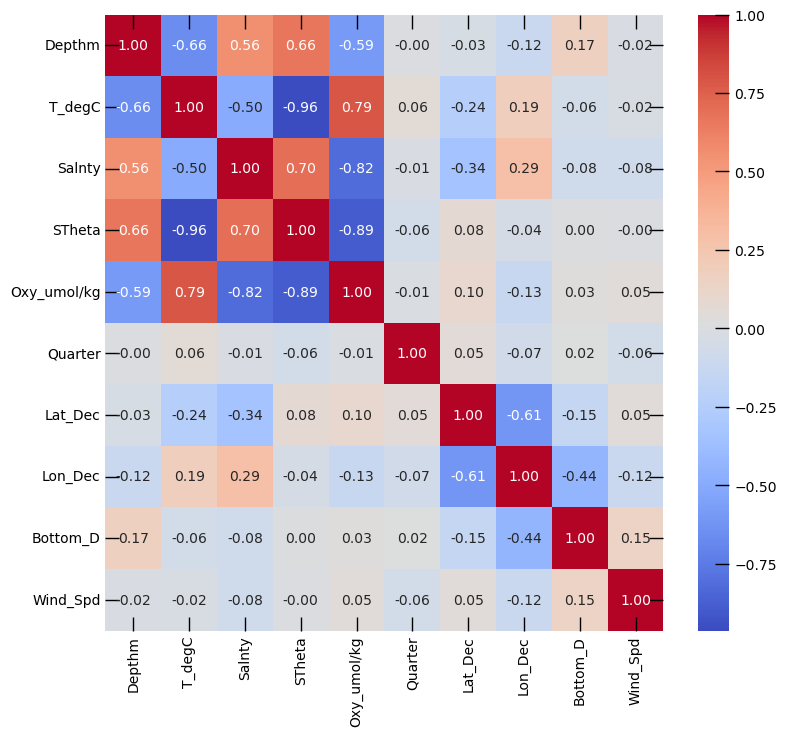

In [6]:
plt.figure(figsize = (9, 8))
plt.rcParams['font.size'] = 10
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.major.width'] = 1
sns.heatmap(chifis_df.corr(), cmap = 'coolwarm', annot= True, fmt = '.2f')
plt.show()

We calculate the correlation among the variables. 

We observe strong positive correlations:
- Salinity vs Water potential density(0.70): this results reflect the physical relation, as higher salinity results in higher water density.
- Density vs Depth(0.66): This is consistent with the fact that water characterized by higer density is heavier.  
- Salinity vs Depth(0.56): This is consistent with the fact that salinity correlates with density, and therefore it is valid the above observation. 
- Temperature vs Oxygen (0.79): this may reflect the fact that water exhibits higher temperatures near the surface, where oxygen levels are also higher due to mixing as well as other processes.

and strong negative correlations: 
- Temperature vs Density (-0.96)
- Temperature vs Depth (-0.67)
- Oxygen vs Depth(-0.59)
- Oxygen vs Salinity (-0.83)
All the observed negative correlations that temperature decreases with depth, and since salinity and potential density increase with depth, they are positively correlated with each other. Similarly, oxygen concentrations decrease with depth, as water further from the surface receives less atmospheric exchange. The observed positive correlation between temperature and oxygen likely reflects surface dynamics, where warmer waters near the surface coincide with higher oxygen levels due to mixing.

- Longitude - Latitude: this is an example of correlation doesn't mean causation. 



These correlations suggest that it is posible to establish a relation among salinity - temperature and potential density

The following plot was taken from [temperature-salinity-geodata](https://www.kaggle.com/code/angelosorge/temperature-salinity-geodata)

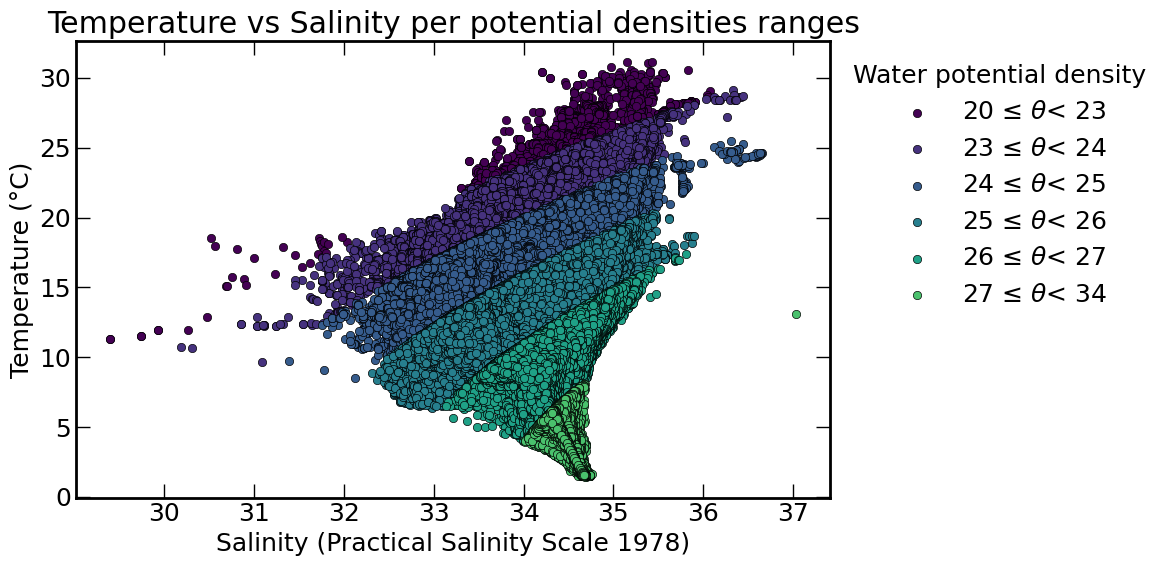

CPU times: user 4.32 s, sys: 97.4 ms, total: 4.42 s
Wall time: 4.42 s


In [231]:
%%time

plt.rcParams['font.size'] = 18
# density steps 
df = chifis_df
theta_step = [20, 23, 24, 25, 26, 27, 34]

norm = colors.Normalize(vmin=0, vmax=len(theta_step))
cmap = plt.cm.viridis

plt.rcParams['figure.figsize'] = (12, 6)

i = 0
for theta1, theta2 in zip(theta_step, theta_step[1:]):
    subset = df[(df['STheta'] >= theta1) & (df['STheta'] < theta2)]
    sns.scatterplot(
        data=subset,
        x="Salnty",
        y="T_degC",
        label=f"{theta1} ≤ "+ r'$\theta$' + f"< {theta2}",
        color=cmap(norm(i)),
        edgecolor='black'
    )
    i = i+1

plt.xlabel("Salinity (Practical Salinity Scale 1978)")
plt.ylabel("Temperature (°C)")
plt.title("Temperature vs Salinity per potential densities ranges")
plt.legend(bbox_to_anchor = (1, 1), title = "Water potential density")
plt.tight_layout()
plt.show()


The data exhibit a qualitative pattern consistent with what is reported in the literature, as illustrated in the graph below.

In [8]:
# import image module
from IPython.display import Image
# get the image
Image(url='https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fhomework.study.com%2Fcimages%2Fmultimages%2F16%2Fdiagram4639199173317639592.png&f=1&nofb=1&ipt=feaa4cc2bed97431bff45b1b961e31935c76f7689180477909487f7ec38b7c31', width=500, height=300)

Less dense water remains at the surface, while denser water sinks. Waters of different densities tend to stratify themselves into layers, with the densest, coldest water on the bottom and warmer, less dense water on top. This is reflected in the plot shown in the followig figure. 

It is the movement of these density layers that create the deep water circulation. Since seawater density depends mainly on temperature and salinity, this circulation is referred to as thermohaline circulation. [INTRODUCTION TO OCEANOGRAPHY](https://rwu.pressbooks.pub/webboceanography/chapter/9-8-thermohaline-circulation/)

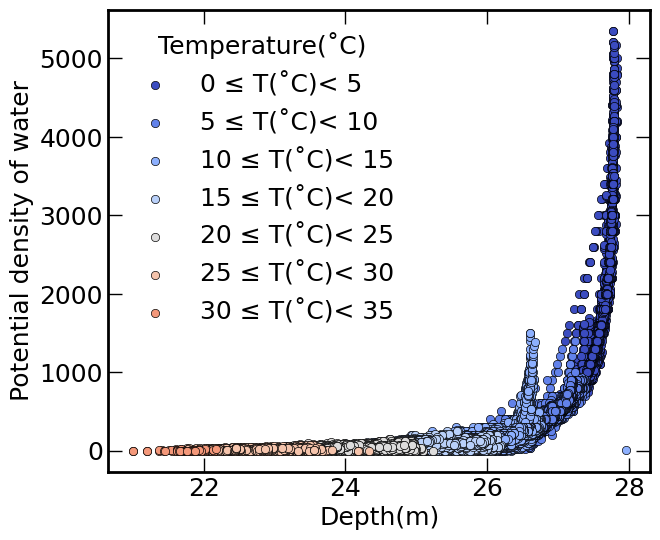

CPU times: user 3.83 s, sys: 69.7 ms, total: 3.9 s
Wall time: 3.9 s


In [9]:
%%time
plt.rcParams['font.size'] = 18

df = chifis_df
# intervalli di densità potenziale
temp_steps = [0, 5, 10, 15, 20, 25, 30, 35]

# normalizzazione per la mappa colori
norm = colors.Normalize(vmin=0, vmax=len(temp_steps))
cmap = plt.cm.coolwarm

plt.rcParams['figure.figsize'] = (7, 6)

# scatter per ogni intervallo
i = 0
for T1, T2 in zip(temp_steps, temp_steps[1:]):
    subset = df[(df['T_degC'] >= T1) & (df['T_degC'] < T2)]
    sns.scatterplot(
        data=subset,
        x="STheta",
        y="Depthm",
        label=f"{T1} ≤ "+ r'T(˚C)' + f"< {T2}",
        color=cmap(norm(i)),
        edgecolor='black'
    )
    i = i+1

plt.xlabel("Depth(m)")
plt.ylabel("Potential density of water")
plt.legend( title = "Temperature(˚C)")
plt.show()


# Metodi di regressione 

Regression is a **supervised learning** method.  
In supervised learning, we have a sequence of datapoints, each associated with a known outcome. The goal of supervised learning is to train a model capable of predicting the outcome for any new input.  

More specifically, the dataset can be represented as:

$$
D = \{(y_1, x_1), (y_2, x_2), \dots, (y_N, x_N)\}, \quad (y_i, x_i) \in \mathbb{R}^{p+q}
$$

In regression problems, the set of labels is continuous, 

$$
Y \subset \mathbb{R}^q
$$

where \(q\) represents the number of labels.  

The design matrix \(X\) can be written as:

$$
X = 
\begin{pmatrix}
1 & x_{1, 1} & \dots & x_{1, p} \\
1 & x_{2, 1} & \dots & x_{2, p} \\
\vdots & \vdots & \ddots & \vdots \\
1 & x_{N, 1} & \dots & x_{N, p}
\end{pmatrix}
=
\begin{pmatrix}
1 & x_1^T \\
1 & x_2^T \\
\vdots & \vdots \\
1 & x_N^T
\end{pmatrix}
$$

where $x_{i,j}$ represents the $j$-th feature of the $i$-th example.  
Thus, 

$$
X \in \mathbb{R}^{N \times p} \quad \text{or} \quad X \in \mathbb{R}^{N \times (p+1)}
$$

depending on whether a bias term is included.



## Ordinary Least Squares 

For simplicity, we proceed by setting $q = 1$. The simplest predictor we can consider is a linear combination of the input variables:

$$
\hat y = f(\mathbf{x}, \beta_0, \mathbf{\beta}) = \beta_0 + \beta_1 x_1 + \dots + \beta_p x_p
$$

where $\beta_0$ is the intercept and $\mathbf{\beta} = (\beta_1, \beta_2, \dots, \beta_p)$.  

This predictor is associated with a quadratic loss function:

$$
l(y, \hat y) = (y - \hat y)^2
$$

The best parameters that describe the known data are those that minimize the cost function:

$$
C(\beta_0, \mathbf{\beta}) = \frac{1}{N} \sum_{i=1}^N (y_i - \hat y_i)^2
$$

Minimizing this cost function corresponds to solving an **Ordinary Least Squares (OLS)** problem.  

The optimal parameters can be computed as:

$$
\hat{\beta} = (X^T X)^{-1} X^T \vec{y}
$$




### Application of OLS

We proceed by performing ordinary least squares (OLS) in two different ways:
- OLS with 2D labels (both temperature and salinity simultaneously).
- OLS on temperature and salinity separately, ignoring the other variable in each case.

To simplify the implementation, we define a function to perform the regression OLS saved in Functions.py file. 

In [10]:
T_S_ols_coef_df, T_S_ols_train, T_S_ols_train_pred, T_S_ols_test, T_S_ols_test_pred = OLS(df=chifis_df, val=False)
T_ols_coef_df, T_ols_train, T_ols_train_pred, T_ols_test, T_ols_test_pred = OLS(df=chifis_df, Y_labels=['T_degC'], drop_labels=['T_degC'], val=False)
S_ols_coef_df, S_ols_train, S_ols_train_pred, S_ols_test, S_ols_test_pred = OLS(df=chifis_df, Y_labels=['Salnty'], drop_labels=['Salnty'], val=False)

### Temperature results - multitarget vs 1 target regression

In this section, we compare the results of predicting temperature using the two approaches. 
We observe dfferences in the coefficients:

In [11]:
## print coefficientts
Temp_results = pd.concat([T_S_ols_coef_df['T_degC'], T_ols_coef_df ], axis = 1)
Temp_results.columns = ['Temperature_T+S_ols', 'Temperature_T_ols']
Temp_results

,Temperature_T+S_ols,Temperature_T_ols
Depthm,-0.200721,-0.438743
STheta,-4.548140,-4.465832
Oxy_umol/kg,-0.790012,0.306837
Quarter,-0.016882,-0.006284
Lat_Dec,-0.627032,-0.162458
Lon_Dec,-0.049806,0.037269
Bottom_D,-0.287941,-0.061103
Wind_Spd,-0.025068,-0.005993
Intercept,10.923575,10.923575
Salnty,NaN,1.463184


The results already provide us with some informations regarding the prediction for the temperature. 
Firstly we observe that the two methods provided us with the same results for the intercept. 
We also observe that the coefficient in the case of multitarget OLS are redistributed over the other features. 
- STheta (water potential density) mantains a strong influence in both methods
- the coefficients for all the other features decreases when ignoring Salinity

the relatively strong importance of STheta and Salnty reflect the correlations found in the begining of this notebook. 

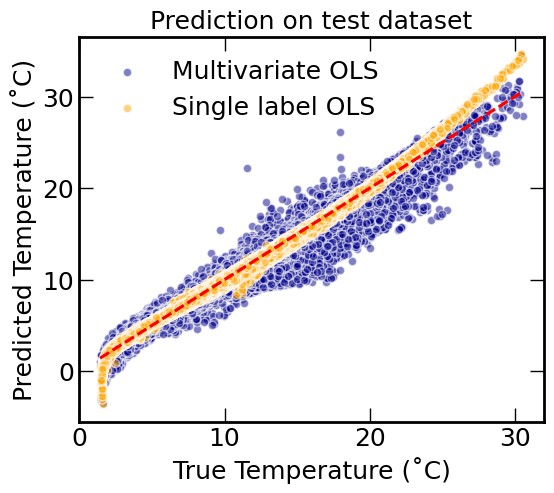

,MSE,MAE,R2
Temperature - T_S_ols - test,0.570245,0.520007,0.967474
Temperature - T_ols - test,0.085829,0.192003,0.995104
Temperature - T_S_ols - train,0.571613,0.518258,0.967290
Temperature - T_ols - train,0.085752,0.192321,0.995093


In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

# Scatter plot per il dataset di validation

ax.set_title('Prediction on test dataset', fontsize = 18)
plot_pred_vs_true(T_S_ols_test['T_degC'], T_S_ols_test_pred[:,0],label='Multivariate OLS', ax = ax, color = 'darkblue')
plot_pred_vs_true(T_ols_test['T_degC'], T_ols_test_pred[:,0],label='Single label OLS',  ax = ax, color = 'orange')

ax.set_xlabel('True Temperature (˚C)')
ax.set_ylabel('Predicted Temperature (˚C)')

ax.legend(loc = 2)
plt.show()

#Temperatura
# Metrics calculated on the test function
T_S_ols_met_test = calculate_metrics(
    np.array(T_S_ols_test['T_degC'].values), 
    T_S_ols_test_pred[:,0]
)
T_S_ols_met_test.index = ['Temperature - T_S_ols - test']

T_ols_met_test = calculate_metrics(
    np.array(T_ols_test.values), 
    T_ols_test_pred[:,0]
)
T_ols_met_test.index = ['Temperature - T_ols - test']


# Metrics calculated on the train function
T_S_ols_met_train = calculate_metrics(
    np.array(T_S_ols_train['T_degC'].values), 
    T_S_ols_train_pred[:,0]
)
T_S_ols_met_train.index = ['Temperature - T_S_ols - train']

T_ols_met_train = calculate_metrics(
    np.array(T_ols_train.values), 
    T_ols_train_pred[:,0]
)
T_ols_met_train.index = ['Temperature - T_ols - train']

# concatenate
pd.concat([T_S_ols_met_test, T_ols_met_test, T_S_ols_met_train, T_ols_met_train])

In [13]:
### saving results in results dictionary 
# multivariate prediction
T_final_results = upload_results('OLS_TS', T_S_ols_coef_df['T_degC'], T_S_ols_met_train, T_S_ols_met_test, T_final_results)
# prediction including Salinity as a feature
T_final_results = upload_results('OLS', T_ols_coef_df['T_degC'], T_ols_met_train, T_ols_met_test, T_final_results)

We comment the results shown in the table and in the figure. 
We observe that from the point of view of the metrics results, the linear regression including salinity gives better results, with respect to the multivariate regression where we considered both Temperature and Salinity as targets. 
This is plobably connected to the fact the Salinity is strongly correlated with the Temperature. 
It is however important to notice that the edges of the prediction are not well represented using the Ordinary linear regression. this is a tipical problem that arises, as linear regression is not able to include non linear behaviour in the prediction. 


### Salinity results

We comment here the results for Salinity. Here the salinity is measured using using the Practical Salinity Scale 1978. Information are found at [salinometry](https://salinometry.com/pss-78/)

In [14]:
Sal_results = pd.concat([T_S_ols_coef_df['Salnty'], S_ols_coef_df], axis = 1)
Sal_results.columns = ['Salinity_T+S_ols', 'Salinity_S_ols']
Sal_results

,Salinity_T+S_ols,Salinity_S_ols
Depthm,0.074707,0.128255
STheta,-0.025834,1.187520
Oxy_umol/kg,-0.344263,-0.133504
Quarter,-0.003326,0.001178
Lat_Dec,-0.145814,0.021466
Lon_Dec,-0.027330,-0.014043
Bottom_D,-0.071197,0.005620
Wind_Spd,-0.005987,0.000701
Intercept,33.835330,33.835330
T_degC,NaN,1.115222


The inclusion of temperature in the salinity regression redistributes the importance among predictors: STheta loses influence and T_degC becomes the dominant explanatory variable. The intercept remains constant, indicating that the baseline level of salinity is stable across models. Minor predictors (Depth, Oxy, geographic coordinates, Wind) have little effect in both models. These results are consistent with the strong correlation between temperature and salinity and suggest that the model including temperature better captures the main variability in salinity, though extreme values may still be less well predicted.

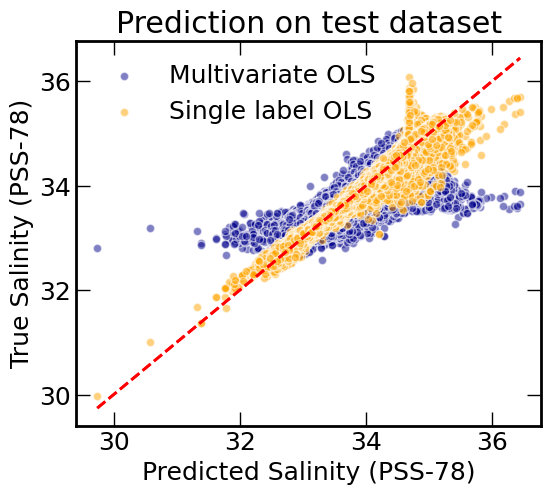

,MSE,MAE,R2
Salinity - T_S_ols - train,0.047863,0.142845,0.773059
Salinity - T_S_ols - test,0.047178,0.143049,0.776635
Salinity - S_ols - train,0.007180,0.054937,0.965955
Salinity - S_ols - test,0.007101,0.054742,0.966380


In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.set_title('Prediction on test dataset')
plot_pred_vs_true(T_S_ols_test['Salnty'], T_S_ols_test_pred[:,1],label='Multivariate OLS', ax = ax, color = 'darkblue')
plot_pred_vs_true(S_ols_test['Salnty'], S_ols_test_pred[:,0],label='Single label OLS',  ax = ax, color = 'orange')
ax.set_xlabel('Predicted Salinity (PSS-78)')
ax.set_ylabel('True Salinity (PSS-78)')

ax.legend(loc = 2)
plt.show()


# Priinting Metrics 
T_S_ols_test_metrics = calculate_metrics(
    np.array(T_S_ols_test['Salnty'].values), 
    T_S_ols_test_pred[:,1]
)
T_S_ols_test_metrics.index = ['Salinity - T_S_ols - test']

S_ols_test_metrics = calculate_metrics(
    np.array(S_ols_test.values), 
    S_ols_test_pred[:,0]
)
S_ols_test_metrics.index = ['Salinity - S_ols - test']


T_S_ols_train_metrics = calculate_metrics(
    np.array(T_S_ols_train['Salnty'].values), 
    T_S_ols_train_pred[:,1]
)
T_S_ols_train_metrics.index = ['Salinity - T_S_ols - train']

S_ols_train_metrics = calculate_metrics(
    np.array(S_ols_train.values), 
    S_ols_train_pred[:,0]
)
S_ols_train_metrics.index = ['Salinity - S_ols - train']

# --- Concatenate all the metrics results 
metrics_df = pd.concat([
    T_S_ols_train_metrics, 
    T_S_ols_test_metrics, 
    S_ols_train_metrics, 
    S_ols_test_metrics
])
metrics_df


For salinity prediction, the single-label OLS (S_ols) performs significantly better than the multi-label OLS (T_S_ols), achieving higher R² and lower MSE/MAE, while both models generalize well as indicated by the similar train and test performances.


In [16]:
### saving results in results dictionary 
# multivariate prediction
S_final_results = upload_results('OLS_TS', T_S_ols_coef_df['Salnty'], T_S_ols_train_metrics, T_S_ols_test_metrics, S_final_results)
# prediction including Salinity as a feature
S_final_results = upload_results('OLS', S_ols_coef_df['Salnty'], S_ols_train_metrics,  S_ols_test_metrics, S_final_results)

## Regularization methods

Regularization methods are techniques used in regression and other predictive models to prevent overfitting by adding a penalty to large coefficients. They are particularly useful when you have multicollinearity (highly correlated features) or a large number of predictors relative to samples.
We present here an introduction to two common regularization methods:
- Reidge Regression
- LASSO regression

**Ridge Regression** is a method for estimating the coefficients of multiple regression models in scenarios where the independent variables are highly correlated. Given the correlation results shown previously, this method should be useful to obtain a better regression.

The cost function is written as:

$$
C(X, \beta) = \frac{1}{n} \|y - X\beta \|_2^2 + \lambda \|\beta \|_2^2
$$

The values of $\beta$ are determined by minimizing this cost function:

$$
\min_{\beta \in \mathbb{R}^p} C(X, \beta)
$$

The resulting coefficients are given by:

$$
\beta^{\text{Ridge}} = (X^T X + \lambda I)^{-1} X^T y
$$



**LASSO regression** is a method for estimating the coefficients of multiple regression models in situations where the independent variables are highly correlated.  

The cost function is written as:  

$$
C(X, \beta) = \frac{1}{n} \|y - X\beta \|_2^2 + \lambda \|\beta \|_1
$$

where  

$$
\|\beta\|_1 = \sum_i |\beta_i|
$$

The values of $\beta$ are determined by minimizing the cost function:  

$$
\min_{\beta \in \mathbb{R}^p} C(X, \beta)
$$

For LASSO regression, there is no analytical solution; instead, an iterative algorithm must be used to estimate the coefficients

### Ridge regression implementation

Similarly to what was done before, we perform the regression and save the results to perform a comparison with the OLS results. 

We define a function to simplify the process and perform Ridge regression (defined in `functions.py`)

To define the most appropriate alpha we define a function to determine the shrinkage parameter that minimize the error. We look for the most appropriate shrinkage parameter on all the features.  

In [21]:


def split_train_target(df, Y_labels=['T_degC','Salnty'], drop_labels=['T_degC','Salnty'], test_size=0.2, random_state=0):
    y = df[Y_labels]
    X = df.drop(columns=drop_labels)
    feature_cols = X.columns
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return y_train, X_train, y_test, X_test, feature_cols

def compute_ridge_cv_mse(alphas, X_train, y_train, cv=5):
    mse_list = []
    for alpha in alphas:
        # Pipeline: scaler + ridge
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha))
        ])
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
        mse_list.append(-np.mean(scores))
    return np.array(mse_list)

def best_ridge_shrinkage(df, Y_labels=['T_degC','Salnty'], drop_labels=['T_degC','Salnty'], 
                         min1=-1, max1=1, min2=-1, max2=-0.5, cv=5, suptitle='Multitarget regression'):
    
    # Splitting train -  test 
    y_train, X_train, y_test, X_test, feature_cols = split_train_target(
        df, Y_labels=Y_labels, drop_labels=drop_labels
    )
    
    # selecting alpha/lambdas ranges 
    alphas_range1 = np.logspace(min1, max1, 50)
    alphas_range2 = np.logspace(min2, max2, 50)
    
    # calculation of MSE through cv 
    mse_cv_1 = compute_ridge_cv_mse(alphas_range1, X_train, y_train, cv)
    mse_cv_2 = compute_ridge_cv_mse(alphas_range2, X_train, y_train, cv)
    
    # best shrinkage parameter 
    best_alpha_1 = alphas_range1[np.argmin(mse_cv_1)]
    best_alpha_2 = alphas_range2[np.argmin(mse_cv_2)]
    
    # Setting  Plot
    fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=False)
    
    axes[0].semilogx(alphas_range1, mse_cv_1, marker='o', color='c', mec = 'black')
    axes[0].axvline(best_alpha_1, color='red', linestyle='--',
                    label=fr'Min MSE at $\lambda$={best_alpha_1:.7f}')
    axes[0].set_xlabel('shrinkage parameter $\lambda$')
    axes[0].set_ylabel('MSE medio K-fold CV')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].semilogx(alphas_range2, mse_cv_2, marker='o', color='c', mec = 'black')
    axes[1].axvline(best_alpha_2, color='red', linestyle='--',
                    label=fr'Min MSE at $\lambda$={best_alpha_2:.7f}')
    axes[1].set_xlabel('shrinkage parameter $\lambda$')
    axes[1].tick_params(axis='x', rotation=45, which='both')
    axes[1].legend()
    axes[1].grid(True)

    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()
    
    print(f'Best lambda (range max) : {best_alpha_1}')
    print(f'Best lambda (range min) : {best_alpha_2}')
    
    return best_alpha_1, best_alpha_2, X_train, y_train, X_test, y_test, feature_cols


We explore the effects of the ridge regression and define the most appropriate parameters using cross validation. 

#### Ridge - Multitarget regression 

We perform a research for the best shrinkage parameter

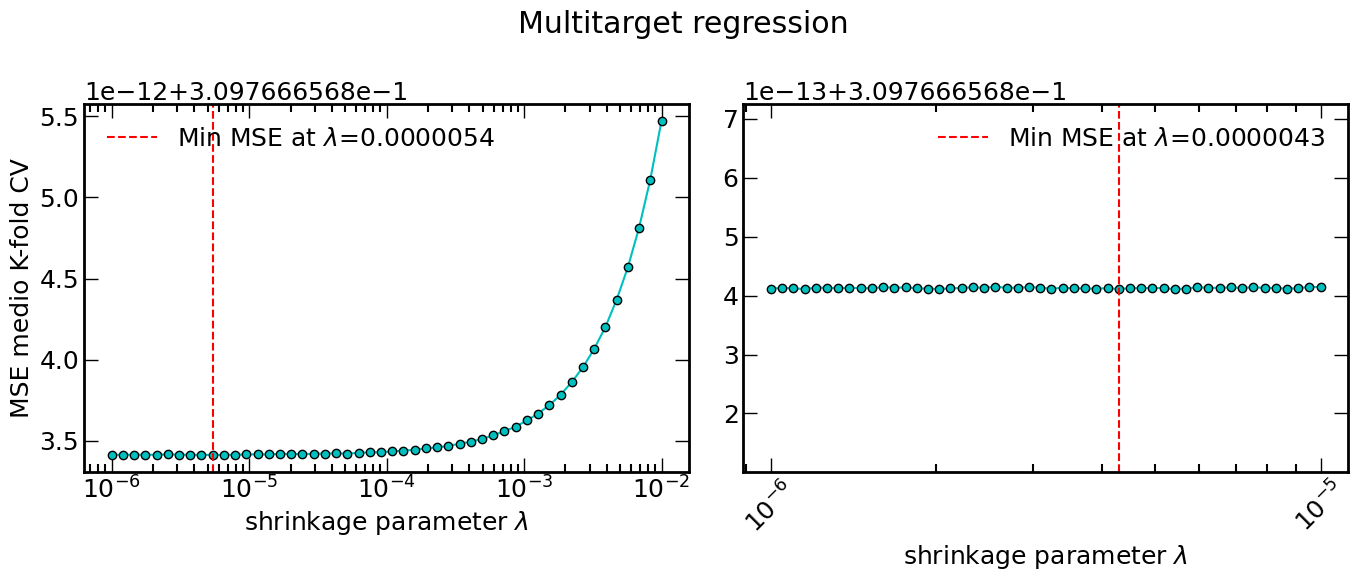

Best lambda (range max) : 5.428675439323859e-06
Best lambda (range min) : 4.291934260128778e-06


In [22]:
TS_ridge_res = best_ridge_shrinkage(df = chifis_df, Y_labels = ['T_degC', 'Salnty'], drop_labels =['T_degC', 'Salnty'], min1 = -6, max1 = -2,min2 = -6, max2 = -5)

best_alpha_1_TS_ridge = TS_ridge_res[0]
best_alpha_2_TS_ridge = TS_ridge_res[1]
X_TS_ridge_train = TS_ridge_res[2]
y_TS_ridge_train = TS_ridge_res[3]
X_TS_ridge_test = TS_ridge_res[4]
y_TS_ridge_test = TS_ridge_res[5]
TS_feature_cols = TS_ridge_res[6]

We use the found paraameter to perform the regression on the test data

We start performing a Ridge regression using a test alpha. 

In [23]:
TS_ridge_res= Ridge_Regression(X_TS_ridge_train, y_TS_ridge_train, X_TS_ridge_test, y_TS_ridge_test, best_alpha_2_TS_ridge)

In [24]:
TS_X_train_scaled = TS_ridge_res[0]
TS_X_test_scaled = TS_ridge_res[1]
TS_y_pred_train = TS_ridge_res[2]
TS_y_pred_test = TS_ridge_res[3]
TS_y_train = TS_ridge_res[4]
TS_y_test = TS_ridge_res[5]
TS_scaler = TS_ridge_res[6]
TS_ridge_model = TS_ridge_res[7]

# Extracting coefficients 
TS_coeff_df = pd.DataFrame(
    TS_ridge_model.coef_.T,  # Trasposta per avere feature come righe
    index=TS_feature_cols,
    columns=['Temperature_T+S_ridge', 'Salinity_T+S_ridge']
)

# adding intercepts 
TS_coeff_df.loc['Intercept'] = TS_ridge_model.intercept_

TS_coeff_df

,Temperature_T+S_ridge,Salinity_T+S_ridge
Depthm,-0.200721,0.074707
STheta,-4.548140,-0.025834
Oxy_umol/kg,-0.790012,-0.344263
Quarter,-0.016882,-0.003326
Lat_Dec,-0.627032,-0.145814
Lon_Dec,-0.049806,-0.027330
Bottom_D,-0.287941,-0.071197
Wind_Spd,-0.025068,-0.005987
Intercept,10.923575,33.835330


We obtain the following coefficients that can be compared with the OLS results. 

For this choice of parameter the difference between the two methods is not perceived. We plot the results comparing the prediction with the true values. 

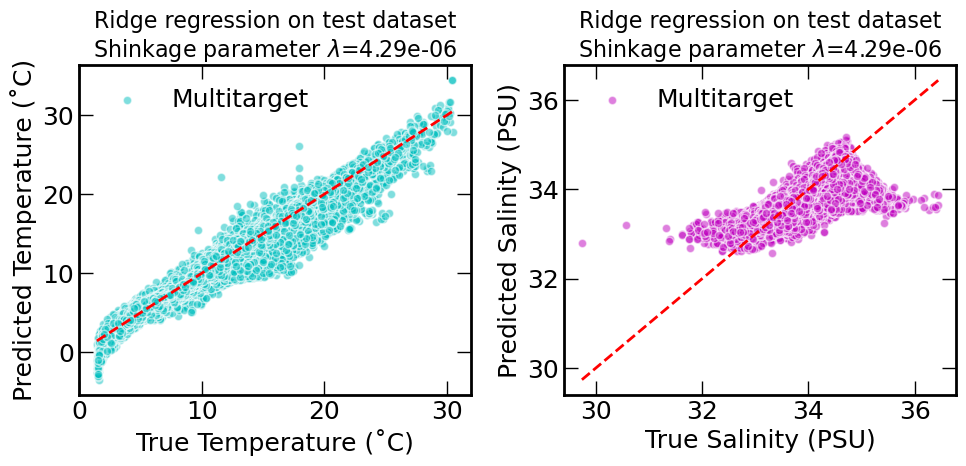

,MSE,MAE,R2
Multitarget - Train,0.309738,0.330552,0.836310
Multitarget - Test,0.308711,0.331528,0.839221
Temperature - Test,0.570245,0.520007,0.966414
Temperature - Train,0.571613,0.518258,0.966183
Salinity - Train,0.047863,0.142845,0.706437
Salinity - Test,0.047178,0.143049,0.712029


In [25]:

fig, ax = plt.subplots(1, 2, figsize=(10,5))

# Temperature plot
ax[0].set_title('Ridge regression on test dataset\n'+r'Shinkage parameter $\lambda$=' + f'{best_alpha_2_TS_ridge:.2e}', fontsize=16)
plot_pred_vs_true(TS_y_test['T_degC'], TS_y_pred_test[:,0], label='Multitarget', ax=ax[0], color='c')
ax[0].set_xlabel('True Temperature (˚C)')
ax[0].set_ylabel('Predicted Temperature (˚C)')
ax[0].legend(loc=2)

# Salinity plot
ax[1].set_title('Ridge regression on test dataset\n'+r'Shinkage parameter $\lambda$=' + f'{best_alpha_2_TS_ridge:.2e}', fontsize=16)
plot_pred_vs_true(TS_y_test['Salnty'], TS_y_pred_test[:,1], label='Multitarget', ax=ax[1], color='m')
ax[1].set_xlabel('True Salinity (PSU)')
ax[1].set_ylabel('Predicted Salinity (PSU)')
ax[1].legend(loc=2)

plt.tight_layout()
plt.show()
TS_y_pred_train = TS_ridge_res[2]
TS_y_pred_test = TS_ridge_res[3]
TS_y_train = TS_ridge_res[4]
TS_y_test = TS_ridge_res[5]
TS_scaler = TS_ridge_res[6]
TS_ridge_model = TS_ridge_res[7]

# == Multi target metrics 
TS_Ridge_metrics_test  = calculate_metrics(np.array(TS_y_pred_test), TS_y_test.values)
TS_Ridge_metrics_train = calculate_metrics(np.array(TS_y_pred_train), TS_y_train.values)

TS_Ridge_metrics_train.index = ['Multitarget - Train']
TS_Ridge_metrics_test.index  = ['Multitarget - Test']

# == Temperature metrics 
T_TS_Ridge_metrics_test  = calculate_metrics(np.array(TS_y_pred_test[:,0]), TS_y_test['T_degC'].values)
T_TS_Ridge_metrics_train = calculate_metrics(np.array(TS_y_pred_train[:,0]), TS_y_train['T_degC'].values)

T_TS_Ridge_metrics_train.index = ['Temperature - Train']
T_TS_Ridge_metrics_test.index  = ['Temperature - Test']

# == Salinity 
S_TS_Ridge_metrics_test  = calculate_metrics(np.array(TS_y_pred_test[:, 1]), TS_y_test['Salnty'].values)
S_TS_Ridge_metrics_train = calculate_metrics(np.array(TS_y_pred_train[:, 1]), TS_y_train['Salnty'].values)

S_TS_Ridge_metrics_train.index = ['Salinity - Train']
S_TS_Ridge_metrics_test.index  = ['Salinity - Test']

metrics_df = pd.concat([
    TS_Ridge_metrics_train,
    TS_Ridge_metrics_test,
    T_TS_Ridge_metrics_test,
    T_TS_Ridge_metrics_train,
    S_TS_Ridge_metrics_train,
    S_TS_Ridge_metrics_test
])
metrics_df

#### Ridge - Temperature

We repeat the previous procedures with a single target regression

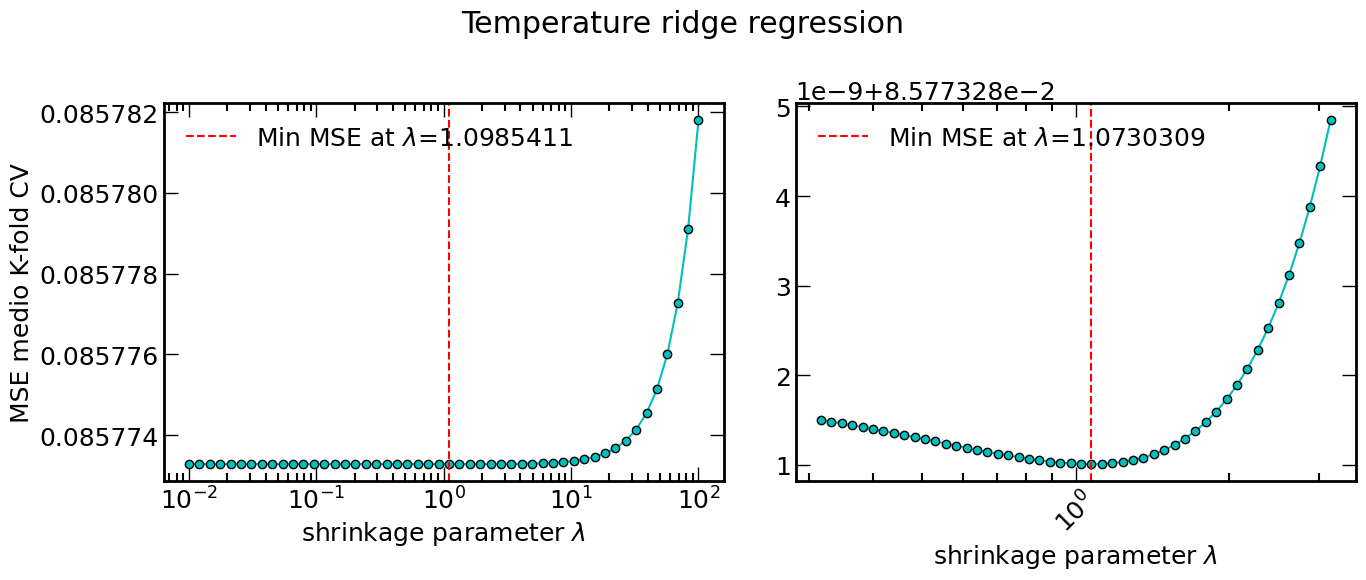

Best lambda (range max) : 1.0985411419875584
Best lambda (range min) : 1.073030940526156


In [26]:
T_ridge_res = best_ridge_shrinkage(df = chifis_df, Y_labels = ['T_degC'], drop_labels =['T_degC'], min1 = -2, max1 = 2,min2 = -0.5, max2 = 0.5, suptitle = 'Temperature ridge regression')

best_alpha_1_T_ridge = T_ridge_res[0]
best_alpha_2_T_ridge = T_ridge_res[1]
X_T_ridge_train = T_ridge_res[2]
y_T_ridge_train = T_ridge_res[3]
X_T_ridge_test = T_ridge_res[4]
y_T_ridge_test = T_ridge_res[5]
T_feature_cols = T_ridge_res[6]

In [27]:
T_ridge_regression_res= Ridge_Regression(X_T_ridge_train, y_T_ridge_train, X_T_ridge_test, y_T_ridge_test, best_alpha_2_T_ridge)

In [28]:
T_X_train_scaled = T_ridge_regression_res[0]
T_X_test_scaled = T_ridge_regression_res[1]
T_y_pred_train = T_ridge_regression_res[2]
T_y_pred_test = T_ridge_regression_res[3]
T_y_train = T_ridge_regression_res[4]
T_y_test = T_ridge_regression_res[5]
T_scaler = T_ridge_regression_res[6]
T_ridge_model = T_ridge_regression_res[7]

# T coefficients 
T_coeff_ridge_df = pd.DataFrame(
    T_ridge_model.coef_.T,  # Trasposta per avere feature come righe
    index=T_feature_cols,
    columns=['Temperature_T_ridge']
)

# Adding intercepts
T_coeff_ridge_df.loc['Intercept'] = T_ridge_model.intercept_

T_coeff_ridge_df

,Temperature_T_ridge
Depthm,-0.438752
Salnty,1.463169
STheta,-4.465769
Oxy_umol/kg,0.306877
Quarter,-0.006279
Lat_Dec,-0.162470
Lon_Dec,0.037272
Bottom_D,-0.061105
Wind_Spd,-0.005995
Intercept,10.923575


In [29]:
T_Ridge_metrics_train = calculate_metrics(
    np.array(T_y_train.values), 
    T_y_pred_train
)
T_Ridge_metrics_train.index = ['Temperature - ridge - train']

T_Ridge_metrics_test = calculate_metrics(
    np.array(T_y_test.values), 
    T_y_pred_test
)
T_Ridge_metrics_test.index = ['Temperature - ridge - test']

# concatenate metrics dataframe
metrics_df = pd.concat([T_Ridge_metrics_train, T_Ridge_metrics_test])
metrics_df


,MSE,MAE,R2
Temperature - ridge - train,0.085752,0.192326,0.995093
Temperature - ridge - test,0.085829,0.192008,0.995104


In [30]:
T_final_results = upload_results('Ridge_T', T_coeff_ridge_df, T_Ridge_metrics_train, T_Ridge_metrics_test, T_final_results)

We compare with a scatterplot the predicted and the real values for y. 

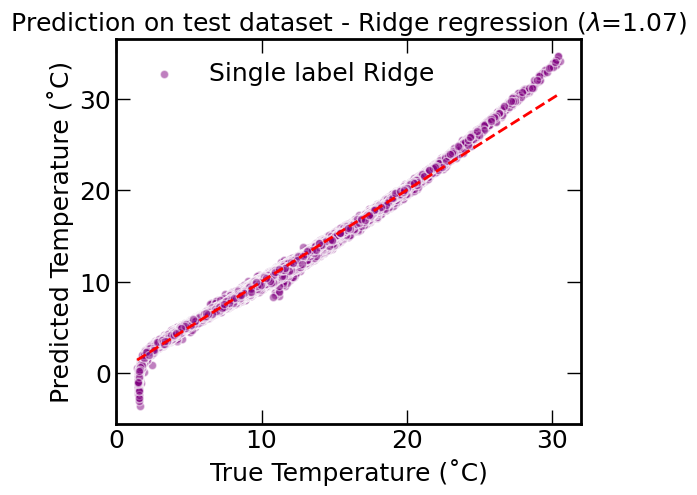

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.set_title(f'Prediction on test dataset - Ridge regression '+r'($\lambda$'+f'={best_alpha_2_T_ridge:.2f})', fontsize = 18)
plot_pred_vs_true(T_y_test.values, T_y_pred_test.ravel(),
                  label='Single label Ridge', ax=ax, color='purple')

ax.set_xlabel('True Temperature (˚C)')
ax.set_ylabel('Predicted Temperature (˚C)')
ax.legend(loc=2)
plt.show()

We observe that even with the Ridge regression using the best shrinkage parameter, the rgression doesn't significantly improve. 

#### Ridge - Salinity

We repeat the previous procedures with a single target regression

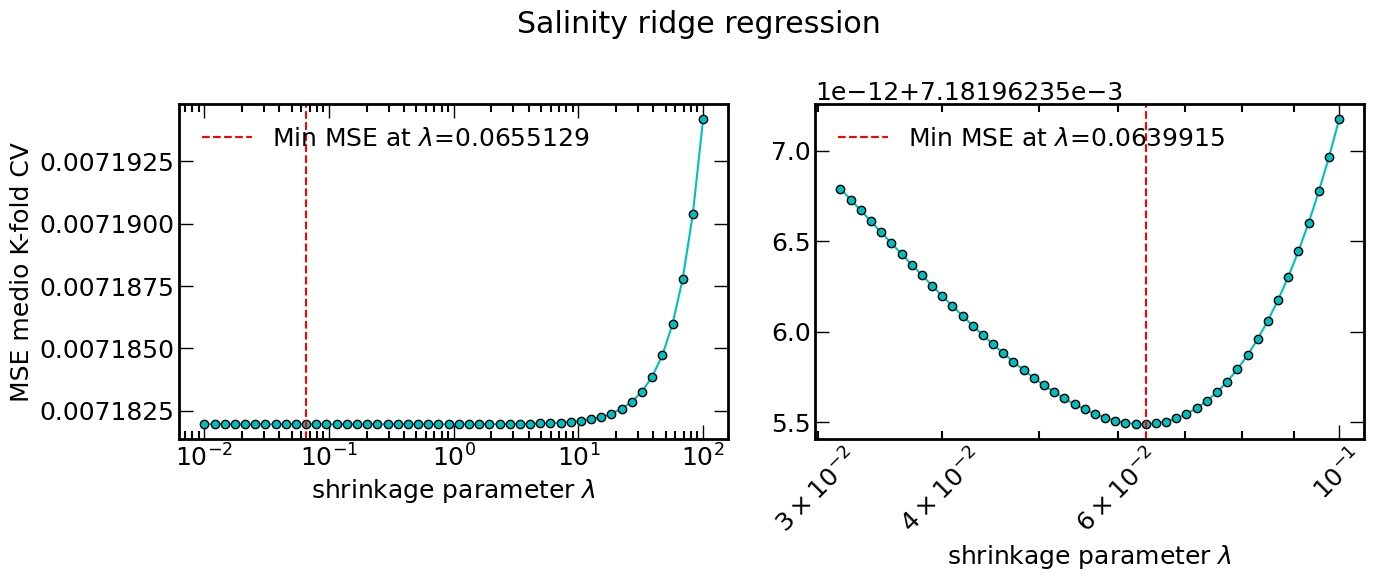

Best lambda (range max) : 0.0655128556859551
Best lambda (range min) : 0.06399152336349263


In [32]:
S_ridge_res = best_ridge_shrinkage(df = chifis_df, Y_labels = ['Salnty'], drop_labels =['Salnty'], min1 = -2, max1 = 2,min2 = -1.5, max2 = -1, suptitle = 'Salinity ridge regression')

best_alpha_1_S_ridge = S_ridge_res[0]
best_alpha_2_S_ridge = S_ridge_res[1]
X_S_ridge_train = S_ridge_res[2]
y_S_ridge_train = S_ridge_res[3]
X_S_ridge_test = S_ridge_res[4]
y_S_ridge_test = S_ridge_res[5]
S_feature_cols = S_ridge_res[6]

In [33]:
S_ridge_regression_res= Ridge_Regression(X_S_ridge_train, y_S_ridge_train, X_S_ridge_test, y_S_ridge_test, best_alpha_2_S_ridge)

In [34]:
S_X_train_scaled = S_ridge_regression_res[0]
S_X_test_scaled = S_ridge_regression_res[1]
S_y_pred_train = S_ridge_regression_res[2]
S_y_pred_test = S_ridge_regression_res[3]
S_y_train = S_ridge_regression_res[4]
S_y_test = S_ridge_regression_res[5]
S_scaler = S_ridge_regression_res[6]
S_ridge_model = S_ridge_regression_res[7]

# coefficients 
S_coeff_ridge_df = pd.DataFrame(
    S_ridge_model.coef_.T,  # Trasposta per avere feature come righe
    index=S_feature_cols,
    columns=['Salinity_ridge']
)

# adding intercepts 
S_coeff_ridge_df.loc['Intercept'] = S_ridge_model.intercept_

S_coeff_ridge_df

,Salinity_ridge
Depthm,0.128255
T_degC,1.115212
STheta,1.187508
Oxy_umol/kg,-0.133507
Quarter,0.001177
Lat_Dec,0.021464
Lon_Dec,-0.014043
Bottom_D,0.005620
Wind_Spd,0.000701
Intercept,33.835330


In [35]:
S_Ridge_metrics_train = calculate_metrics(
    np.array(S_y_train.values), 
    S_y_pred_train
)
S_Ridge_metrics_train.index = ['Salinity - ridge - train']

S_Ridge_metrics_test = calculate_metrics(
    np.array(S_y_test.values), 
    S_y_pred_test
)
S_Ridge_metrics_test.index = ['Salinity - ridge - test']

# concatenate metrics dfs
metrics_df = pd.concat([S_Ridge_metrics_train, S_Ridge_metrics_test])
metrics_df


,MSE,MAE,R2
Salinity - ridge - train,0.007180,0.054937,0.965955
Salinity - ridge - test,0.007101,0.054742,0.966380


In [36]:
S_final_results = upload_results('Ridge_S', S_coeff_ridge_df, S_Ridge_metrics_train, S_Ridge_metrics_test, S_final_results)

We compare with a scatterplot the predicted and the real values for y. 

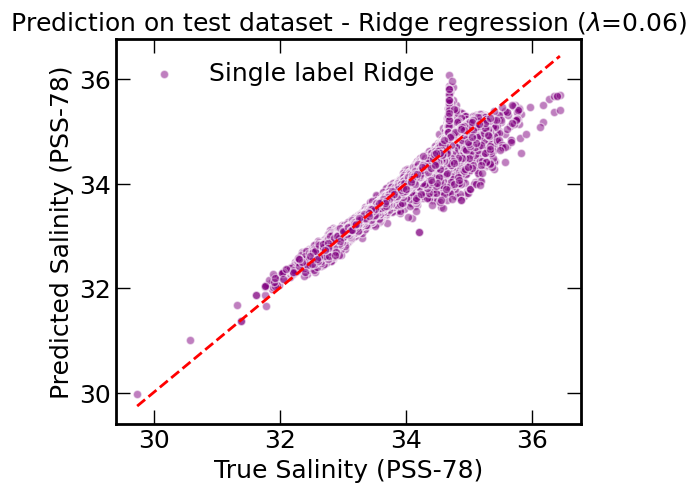

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.set_title(f'Prediction on test dataset - Ridge regression '+r'($\lambda$'+f'={best_alpha_2_S_ridge:.2f})', fontsize = 18)
plot_pred_vs_true(S_y_test.values, S_y_pred_test.ravel(),
                  label='Single label Ridge', ax=ax, color='purple')

ax.set_xlabel('True Salinity (PSS-78)')
ax.set_ylabel('Predicted Salinity (PSS-78)')
ax.legend(loc=2)
plt.show()

In [39]:
S_final_results = upload_results('Ridge_T', S_coeff_ridge_df, S_Ridge_metrics_train, S_Ridge_metrics_test, S_final_results)

We implement functions similar tu the one introduced before

### LASSO regression implementation 

Similarly to what was performed before for Ridge regression, we impemente function to perform a LASSO regression

In [44]:
# Function to calculate mean mse lasso
def compute_cv_mse_lasso(alphas, X, y, cv, max_iter = 50000):

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    mse_list = []
    for alpha in alphas:
        #lasso = Lasso(alpha=alpha, max_iter=max_iter)
        lasso = MultiOutputRegressor(Lasso(alpha=alpha, max_iter=50000))

        # cross_val_score expects model, features, target, cv, scoring
        scores = cross_val_score(lasso, X_scaled, y, cv=cv, scoring='neg_mean_squared_error')
        mse_list.append(-np.mean(scores))
    
    return np.array(mse_list)

In [45]:

def best_shrinkage_lasso(df=chifis_df, Y_labels=['T_degC', 'Salnty'], drop_labels=['T_degC', 'Salnty'],
                         min1=-1, max1=1, min2=-1, max2=-0.5, cv=5, N = 50):
    
    # definite X and y
    y_train, X_train, y_test, X_test, feature_cols =split_train_target(df, Y_labels=Y_labels, drop_labels=drop_labels, test_size=0.3)
    
    # Define shrinkage parameters ranges
    alphas_range1 = np.logspace(min1, max1, N)  
    alphas_range2 = np.logspace(min2, max2, N)    
    

    # CAlculate mse 
    mse_cv_1 = compute_cv_mse_lasso(alphas_range1, X_train, y_train, cv)
    mse_cv_2 = compute_cv_mse_lasso(alphas_range2, X_train, y_train, cv)
    
    # Determine best parameter 
    best_alpha_1 = alphas_range1[np.argmin(mse_cv_1)]
    best_alpha_2 = alphas_range2[np.argmin(mse_cv_2)]
    
    # paired plots 
    fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=False)

    axes[0].semilogx(alphas_range1, mse_cv_1, marker='o', color='c', mec = 'black')
    axes[0].axvline(best_alpha_1, color='red', linestyle='--', label=f'Min MSE at α={best_alpha_1:.2e}')
    axes[0].set_xlabel('$\lambda$')
    axes[0].set_ylabel('mean MSE K-fold CV')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].semilogx(alphas_range2, mse_cv_2, marker='o', color='c', mec = 'black')
    axes[1].axvline(best_alpha_2, color='red', linestyle='--', label=f'Min MSE at α={best_alpha_2:.2e}')
    axes[1].set_xlabel('$\lambda$')
    axes[1].tick_params(axis='x', rotation=45, which='both')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    print(f'Miglior alpha (range max) : {best_alpha_1}')
    print(f'Miglior alpha (range min) : {best_alpha_2}')
    
    return best_alpha_1, best_alpha_2,  y_train, X_train, y_test, X_test, feature_cols



#### LASSO regression - multitarget 

We implement the LASSO regression similarly to what was done before. 

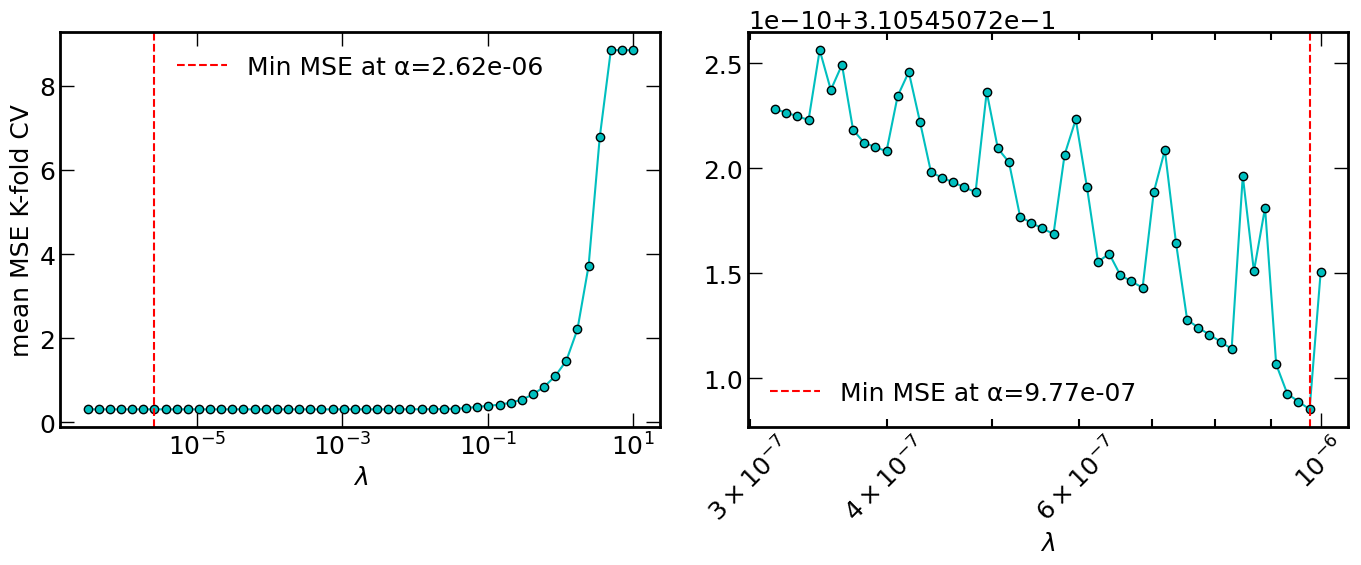

Miglior alpha (range max) : 2.6203985288583486e-06
Miglior alpha (range min) : 9.767781100894883e-07
CPU times: user 10min 33s, sys: 48.3 s, total: 11min 22s
Wall time: 1min 34s


In [46]:
%%time
TS_lasso_results = best_shrinkage_lasso(df = chifis_df, Y_labels = ['T_degC', 'Salnty'], drop_labels =['T_degC', 'Salnty'], min1 = -6.5, max1 = 1,min2 = -6.5, max2 = -6)

In [47]:
best_alpha_1_TS_lasso = TS_lasso_results[0]
best_alpha_2_TS_lasso = TS_lasso_results[1]
X_TS_lasso_train = TS_lasso_results[2]
y_TS_lasso_train = TS_lasso_results[3]
X_TS_lasso_test = TS_lasso_results[4]
y_TS_lasso_test = TS_lasso_results[5]
TS_feature_cols = TS_lasso_results[6]

In [49]:
def Lasso_MultiOutputRegressor(X_train, y_train, X_test, y_test, feature_cols, Y_labels, alpha=0.01):
    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    # multitarget 
    lasso = MultiOutputRegressor(Lasso(alpha=alpha, max_iter=50000))
    lasso.fit(X_train_scaled, y_train)
    
    # coeff
    coef_dict = {}
    intercept_dict = {}
    
    for i, target in enumerate(Y_labels):
        coef_dict[target] = lasso.estimators_[i].coef_
        intercept_dict[target] = lasso.estimators_[i].intercept_
    
    coef_df = pd.DataFrame(coef_dict, index=feature_cols)
    coef_df.loc['Intercept'] = intercept_dict
    
    # prediction
    y_train_pred = lasso.predict(X_train_scaled)
    y_test_pred  = lasso.predict(X_test_scaled)
    
    return coef_df, y_train, y_train_pred, y_test, y_test_pred


In [124]:
TS_lasso_coef_df, TS_lasso_y_train, TS_lasso_y_train_pred, TS_lasso_y_test, TS_lasso_y_test_pred = Lasso_MultiOutputRegressor(y_TS_lasso_train, X_TS_lasso_train, y_TS_lasso_test, X_TS_lasso_test, 
                                                                       TS_feature_cols,['T_degC', 'Salnty'], alpha=best_alpha_2_TS_lasso ) 

In [125]:
TS_lasso_coef_df.columns=['Temperature_T+S_lasso', 'Salinity_T+S_lasso']
TS_lasso_coef_df

,Temperature_T+S_lasso,Salinity_T+S_lasso
Depthm,-0.200723,0.074721
STheta,-4.548070,-0.024826
Oxy_umol/kg,-0.788181,-0.343490
Quarter,-0.016421,-0.003212
Lat_Dec,-0.627506,-0.145956
Lon_Dec,-0.048613,-0.026927
Bottom_D,-0.287558,-0.070918
Wind_Spd,-0.025243,-0.006114
Intercept,10.923803,33.835556


We obtain the following coefficients that can be compared with the OLS results. 

For this choice of parameter the difference between the two methods is not perceived. We plot the results comparing the prediction with the true values. 

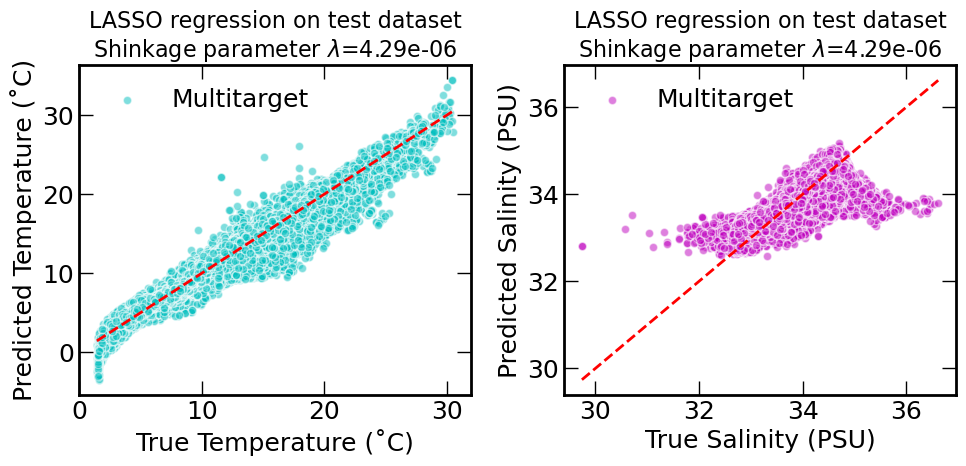

,MSE,MAE,R2
Multitarget - Train,0.310502,0.330911,0.836339
Multitarget - Test,0.307270,0.330480,0.838204
Temperature - Test,0.567243,0.518214,0.966473
Temperature - Train,0.573094,0.518878,0.966119
Salinity - Train,0.047910,0.142943,0.706560
Salinity - Test,0.047297,0.142746,0.709935


In [126]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# Temperature
ax[0].set_title('LASSO regression on test dataset\n'+r'Shinkage parameter $\lambda$=' + f'{best_alpha_2_TS_ridge:.2e}', fontsize=16)
plot_pred_vs_true(TS_lasso_y_test['T_degC'], TS_lasso_y_test_pred[:,0], label='Multitarget', ax=ax[0], color='c')
ax[0].set_xlabel('True Temperature (˚C)')
ax[0].set_ylabel('Predicted Temperature (˚C)')
ax[0].legend(loc=2)

# Salinity
ax[1].set_title('LASSO regression on test dataset\n'+r'Shinkage parameter $\lambda$=' + f'{best_alpha_2_TS_ridge:.2e}', fontsize=16)
plot_pred_vs_true(TS_lasso_y_test['Salnty'], TS_lasso_y_test_pred[:,1], label='Multitarget', ax=ax[1], color='m')
ax[1].set_xlabel('True Salinity (PSU)')
ax[1].set_ylabel('Predicted Salinity (PSU)')
ax[1].legend(loc=2)

plt.tight_layout()
plt.show()
TS_y_pred_train = TS_lasso_res[2]
TS_y_pred_test = TS_lasso_res[3]
TS_y_train = TS_lasso_res[4]
TS_y_test = TS_lasso_res[5]
TS_scaler = TS_lasso_res[6]
TS_ridge_model = TS_lasso_res[7]

# == Multi target metrics 
TS_Lasso_metrics_test  = calculate_metrics(np.array(TS_lasso_y_test_pred), TS_lasso_y_test.values)
TS_Lasso_metrics_train = calculate_metrics(np.array(TS_lasso_y_train_pred), TS_lasso_y_train.values)

TS_Lasso_metrics_train.index = ['Multitarget - Train']
TS_Lasso_metrics_test.index  = ['Multitarget - Test']

# == Temperature metrics 
T_TS_Lasso_metrics_test  = calculate_metrics(np.array(TS_lasso_y_test_pred[:,0]), TS_lasso_y_test['T_degC'].values)
T_TS_Lasso_metrics_train = calculate_metrics(np.array(TS_lasso_y_train_pred[:,0]), TS_lasso_y_train['T_degC'].values)

T_TS_Lasso_metrics_train.index = ['Temperature - Train']
T_TS_Lasso_metrics_test.index  = ['Temperature - Test']

# == Salinity 
S_TS_Lasso_metrics_test  = calculate_metrics(np.array(TS_lasso_y_test_pred[:, 1]), TS_lasso_y_test['Salnty'].values)
S_TS_Lasso_metrics_train = calculate_metrics(np.array(TS_lasso_y_train_pred[:, 1]), TS_lasso_y_train['Salnty'].values)

S_TS_Lasso_metrics_train.index = ['Salinity - Train']
S_TS_Lasso_metrics_test.index  = ['Salinity - Test']

metrics_df = pd.concat([
    TS_Lasso_metrics_train,
    TS_Lasso_metrics_test,
    T_TS_Lasso_metrics_test,
    T_TS_Lasso_metrics_train,
    S_TS_Lasso_metrics_train,
    S_TS_Lasso_metrics_test
])
metrics_df

#### LASSO regression - Temperature 

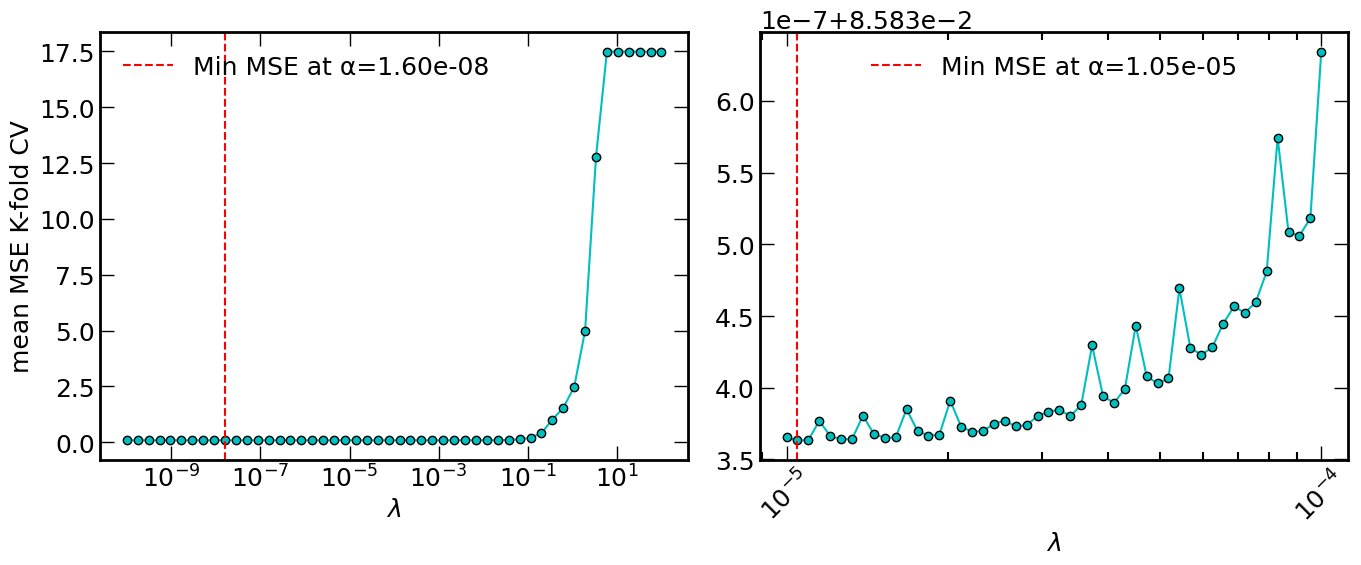

Miglior alpha (range max) : 1.5998587196060573e-08
Miglior alpha (range min) : 1.0481131341546853e-05


In [148]:
T_lasso_res = best_shrinkage_lasso(df = chifis_df, Y_labels = ['T_degC'], drop_labels =['T_degC'], min1 = -10, max1 = 2,min2 = -5, max2 = -4)

best_alpha_1_T_lasso = T_lasso_res[0]
best_alpha_2_T_lasso = T_lasso_res[1]
y_T_lasso_train = T_lasso_res[2]
X_T_lasso_train = T_lasso_res[3]
y_T_lasso_test= T_lasso_res[4]
X_T_lasso_test = T_lasso_res[5]
T_feature_cols = T_lasso_res[6]

In [150]:
def Lasso_Regressor(X_train, y_train, X_test, y_test, feature_cols, Y_labels, alpha=0.01):
    # standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    # lasso regression
    lasso = Lasso(alpha=alpha, max_iter=50000)
    lasso.fit(X_train_scaled, y_train)
    
    '''coef_df = pd.DataFrame(lasso.coef_, index=feature_cols)
    coef_df.loc['Intercept'] = lasso.intercept_'''
    
    # prediction
    y_train_pred = lasso.predict(X_train_scaled)
    y_test_pred  = lasso.predict(X_test_scaled)
    
    return lasso, y_train, y_train_pred, y_test, y_test_pred

In [170]:
T_lasso_regression_res= Lasso_Regressor(X_T_lasso_train, y_T_lasso_train, X_T_lasso_test, y_T_lasso_test,T_feature_cols, ['T_degC'], best_alpha_2_T_lasso)
T_lasso_model = T_lasso_regression_res[0]
T_y_train = T_lasso_regression_res[1]
T_y_pred_train = T_lasso_regression_res[2]
T_y_test = T_lasso_regression_res[3]
T_y_pred_test = T_lasso_regression_res[4]

# coefficients 
T_coeff_lasso_df = pd.DataFrame(
    T_lasso_model.coef_,  
    index=T_feature_cols,
    columns=['Temperature_T_lasso']
)

# adding intercepts
T_coeff_lasso_df.loc['Intercept'] = T_lasso_model.intercept_

T_coeff_lasso_df

,Temperature_T_lasso
Depthm,-0.439003
Salnty,1.465506
STheta,-4.468931
Oxy_umol/kg,0.307193
Quarter,-0.006167
Lat_Dec,-0.162013
Lon_Dec,0.037280
Bottom_D,-0.061375
Wind_Spd,-0.005732
Intercept,10.923803


In [166]:
T_Lasso_metrics_train = calculate_metrics(
    np.array(T_y_train.values), 
    T_y_pred_train
)
T_Lasso_metrics_train.index = ['Temperature - lasso - train']

T_Lasso_metrics_test = calculate_metrics(
    np.array(T_y_test.values), 
    T_y_pred_test
)
T_Lasso_metrics_test.index = ['Temperature - lasso - test']

# Concateno i DataFrame delle metriche
metrics_df = pd.concat([T_Lasso_metrics_train, T_Lasso_metrics_test])
metrics_df


,MSE,MAE,R2
Temperature - lasso - train,0.085810,0.192417,0.995093
Temperature - lasso - test,0.085666,0.191687,0.995100


In [167]:
T_final_results = upload_results('Lasso_T', T_coeff_lasso_df, T_Lasso_metrics_train, T_Lasso_metrics_test, T_final_results)

We compare with a scatterplot the predicted and the real values for y. 

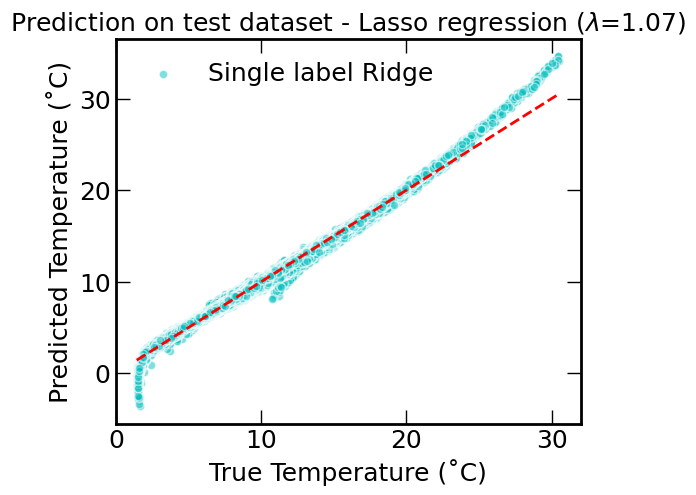

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.set_title(f'Prediction on test dataset - Lasso regression '+r'($\lambda$'+f'={best_alpha_2_T_ridge:.2f})', fontsize = 18)
plot_pred_vs_true(T_y_test.values, T_y_pred_test.ravel(),
                  label='Single label Ridge', ax=ax, color='c')

ax.set_xlabel('True Temperature (˚C)')
ax.set_ylabel('Predicted Temperature (˚C)')
ax.legend(loc=2)
plt.show()

And we focus on the regression of the temperature as a function of the complete set of features. 

#### LASSO regression - Salinity

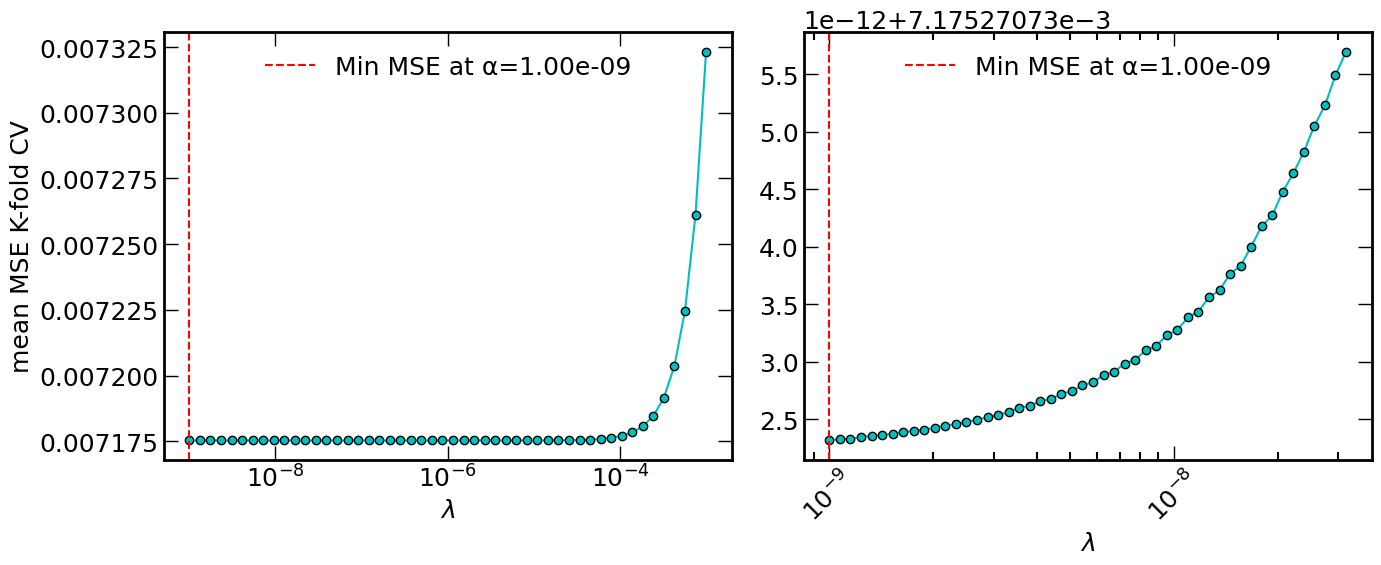

Miglior alpha (range max) : 1e-09
Miglior alpha (range min) : 1e-09


In [193]:
S_lasso_res = best_shrinkage_lasso(df = chifis_df, Y_labels = ['Salnty'], drop_labels =['Salnty'], min1 = -9, max1 = -3,min2 = -9, max2 = -7.5)

best_alpha_1_S_lasso = S_lasso_res[0]
best_alpha_2_S_lasso = S_lasso_res[1]
y_S_lasso_train = S_lasso_res[2]
X_S_lasso_train = S_lasso_res[3]
y_S_lasso_test= S_lasso_res[4]
X_S_lasso_test = S_lasso_res[5]
S_feature_cols = S_lasso_res[6]

In [194]:
S_lasso_regression_res= Lasso_Regressor(X_S_lasso_train, y_S_lasso_train, X_S_lasso_test, y_S_lasso_test,S_feature_cols, ['Salnty'], best_alpha_2_S_lasso)
S_lasso_model = S_lasso_regression_res[0]
S_y_train = S_lasso_regression_res[1]
S_y_pred_train = S_lasso_regression_res[2]
S_y_test = S_lasso_regression_res[3]
S_y_pred_test = S_lasso_regression_res[4]


# coefficients 
S_coeff_lasso_df = pd.DataFrame(
    S_lasso_model.coef_,  
    index=S_feature_cols,
    columns=['Salinity_T_lasso']
)

# adding intercepts 
S_coeff_lasso_df.loc['Intercept'] = S_lasso_model.intercept_

S_coeff_lasso_df

,Salinity_T_lasso
Depthm,0.128239
T_degC,1.114923
STheta,1.187727
Oxy_umol/kg,-0.133362
Quarter,0.001164
Lat_Dec,0.021341
Lon_Dec,-0.013972
Bottom_D,0.005745
Wind_Spd,0.000615
Intercept,33.835556


In [195]:
S_Lasso_metrics_train = calculate_metrics(
    np.array(S_y_train.values), 
    S_y_pred_train
)
S_Lasso_metrics_train.index = ['Salinity - lasso - train']

S_Lasso_metrics_test = calculate_metrics(
    np.array(S_y_test.values), 
    S_y_pred_test
)
S_Lasso_metrics_test.index = ['Salinity - lasso - test']

# Concateno i DataFrame delle metriche
metrics_df = pd.concat([S_Lasso_metrics_train, S_Lasso_metrics_test])
metrics_df


,MSE,MAE,R2
Salinity - lasso - train,0.007174,0.054956,0.966031
Salinity - lasso - test,0.007143,0.054675,0.966061


In [196]:
S_final_results = upload_results('Lasso_S', S_coeff_lasso_df, S_Lasso_metrics_train, S_Lasso_metrics_test, S_final_results)

We compare with a scatterplot the predicted and the real values for y. 

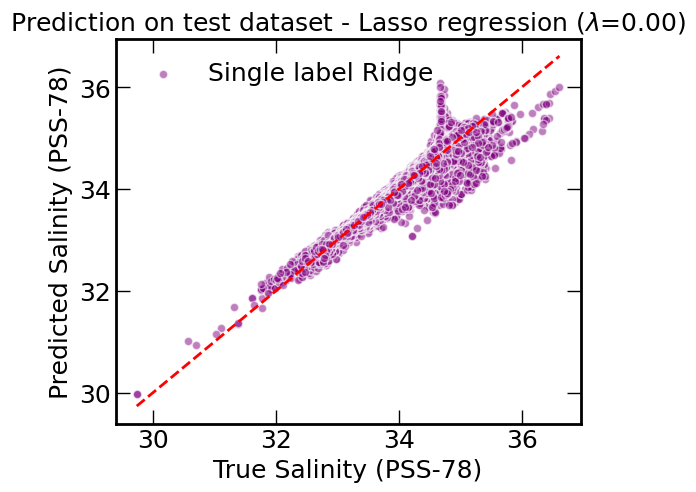

In [197]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

ax.set_title(f'Prediction on test dataset - Lasso regression '+r'($\lambda$'+f'={best_alpha_2_S_lasso:.2f})', fontsize = 18)
plot_pred_vs_true(S_y_test.values, S_y_pred_test.ravel(),
                  label='Single label Ridge', ax=ax, color='purple')

ax.set_xlabel('True Salinity (PSS-78)')
ax.set_ylabel('Predicted Salinity (PSS-78)')
ax.legend(loc=2)
plt.show()

### OLS, Ridge, LASSO coefficient comparison

In the previous section, we obtained the coefficients using OLS and also applied regularization methods, namely Ridge and LASSO.
Through cross-validation, we identified the optimal regularization parameters for both Ridge and LASSO and used them to perform predictions.
The resulting coefficient curves showed only minor variations with changes in the regularization strength $\lambda$, indicating that the models were relatively stable with respect to the choice of the shrinkage parameter.
That is also visible if we observe the coefficient which did not change significantly. 

## Kernel di MERCER

Kernel methods are introduced to incorporate nonlinearity into a problem, for example by replacing the input variables with generalized features. Let $K(x, x') \geq 0$ be a measure of similarity between objects $x, x' \in \mathcal{X}$, where the feature domain $\mathcal{X}$ is an abstract space.  

We call $K$ a **kernel function**. We aim to expand our predictor in terms of a set of $P$ basis functions. Formally, we define a map 

$$
h: \mathbb{R}^p \rightarrow \mathbb{R}^P
$$

that collects the values of each individual basis function evaluated for a specific input feature:  

$$
h(x) = 
\begin{pmatrix}
\phi_1(\mathbf{x}) \\
\phi_2(\mathbf{x}) \\
\vdots \\
\phi_P(\mathbf{x})
\end{pmatrix}
$$

Linear regression is then performed on the values taken from the functions $\phi_l(\cdot)$, so the predictors become:

$$
\hat f(x) = \alpha^T h(x) = \sum_{l=1}^{P} \alpha_l \phi_l(x)
$$

where $\alpha \in \mathbb{R}^P$ and $x \in \mathbb{R}^p$.  

It can be shown that a function 

$$
K: \mathcal{X} \times \mathcal{X} \rightarrow \mathbb{R}
$$

is a kernel and has a corresponding set of generalized feature functions if and only if any finite matrix $K$ with entries $K_{i,j} = K(x_i, x_j)$ is positive semidefinite, i.e.,

$$
\forall m \in \mathbb{N}, \, \forall x_1, \dots, x_m \in \mathcal{X}: \quad z^T K z \geq 0 \quad \forall z \in \mathbb{R}^m
$$

This type of kernel is called a **Mercer kernel**.  

Mercer’s theorem states that if a symmetric function $K(x, x')$ is positive definite, then it admits an expansion in terms of generalized feature functions $h(x)^T h(x')$, and vice versa.


For linear regression, the generalised desing matrix has dimensions $N\times P$
$$
   \mathbf{X} = \begin{pmatrix} \phi_1(\boldsymbol{x}_1)  & \phi_2(\boldsymbol{x}_1) & \cdots & \phi_P(\boldsymbol{x}_1) \\
                                \phi_1(\boldsymbol{x}_2)  & \phi_2(\boldsymbol{x}_2) & \cdots & \phi_P(\boldsymbol{x}_2) \\
                                \vdots & \vdots & & \vdots \\
                                \phi_1(\boldsymbol{x}_N)  & \phi_2(\boldsymbol{x}_N) & \cdots & \phi_P(\boldsymbol{x}_N) 
                \end{pmatrix} 
                = \begin{pmatrix}
\boldsymbol{h}(\boldsymbol{x}_1)^T \\
\boldsymbol{h}(\boldsymbol{x}_2)^T \\ \vdots \\
\boldsymbol{h}(\boldsymbol{x}_N)^T
\end{pmatrix} \,.
$$

The best fit parameters for linear regression predictor with a Ridge regulation are given by
$$
 \boldsymbol{\alpha} = \left( \mathbf{X}^T \mathbf{X} + \lambda \mathbb{I}^{(P\times P)} \right)^{-1} \, \mathbf{X}^T \, \vec{y}
     =  \mathbf{X}^T \, \left( \mathbf{X} \mathbf{X}^T + \lambda \mathbb{I}^{(N\times N)} \right)^{-1} \,  \vec{y} \,.
$$
where we used the matrix relation relation
$$
  A C = B A \quad \implies \quad \frac 1 B A = A \frac 1 C
$$
valid for invertible matrices $B$ and $C$.
The optimal linear predictor becomes
$$
 \begin{aligned}
 \hat{f}(\boldsymbol{x}) ={}& \boldsymbol{\alpha}^T  \boldsymbol{h}(\boldsymbol{x}) \\
                         ={}& \vec{y}^T \, \left( \mathbf{X} \mathbf{X}^T + \lambda \mathbb{I}^{(N\times N)} \right)^{-1} \, \mathbf{X} \, \boldsymbol{h}(\boldsymbol{x}) \, .
 \end{aligned}
$$
The form on the last line allows us to apply the Kernel trick after recognising that the elements of the matrix being inverted are scalar products in the space of generalised features, 
$[\mathbf{X} \mathbf{X}^T]_{ij}= \boldsymbol{h}(\boldsymbol{x}_i)^T \, \boldsymbol{h}(\boldsymbol{x}_j)$,  and similarly for the vector $\mathbf{X} \, \boldsymbol{h}(\boldsymbol{x})$. After substituting the Kernel we have the final form of our predictor:
$$
 \hat{f}(\boldsymbol{x}) = \sum_{i,j=1}^N y_i \left[ K(\boldsymbol{x}_i,\boldsymbol{x}_j) + \lambda \mathbb{I}_{ij} \right]^{-1} K(\boldsymbol{x}_j,\boldsymbol{x}) \,.
$$

Note that this relation involves the inversion of a matrix of dimensions $N\times N$ and it can be substantially larger than the number of features $p$. Nevertheless, the inversion is required only once. Every new prediction requires only the $N$ kernels w.r.t. the training points, $K(\boldsymbol{x}_j,\boldsymbol{x})$, and a vector-vector multiplication that are both processes of $O(N)$.

It is important to remember that sufficiently sophisticated choice of the kernel can imply a very large number of effective degrees of freedom, $P$. Unless the training set includes a sufficiently large number of examples, the model is likely to overfit.  

We propose to use two different kernels:
- The **Polynomial kernel** is given by $K_n(\boldsymbol{x}_a,\boldsymbol{x}_b) = (1 + \boldsymbol{x}_a^T \boldsymbol{x}_b)^n \, , \quad n\in\mathbb{N}$
and it generates the Hilbert space of all polynomials up to degree $n$.
- The **gaussian Kernel** is $K_\gamma(\boldsymbol{x}_a,\boldsymbol{x}_b) = \exp \left\{-\frac 1 {2\gamma} ||\boldsymbol{x}_a-\boldsymbol{x}_b||^2 \right\} \, \quad \text{for } \gamma > 0\,.$

In the following part we apply the two kernels introduced on Temperature and Salinity. 
The kernels methods can be computationally extremely expensive, therefore we propose two ways to use the Nystroem approximation. 

In [96]:
def prepare_data(df, features, targets, test_size=0.2, random_state=42):
    
    # determining features and targets 

    X = df[features]
    y = df[targets] 
    
    # splitting between train and test 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=True
    )
    
    # scaling 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Add intercept 
    X_train_scaled = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
    X_test_scaled = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

    return X_train_scaled, X_test_scaled, y_train, y_test


def kernel_train_predict(X_train, y_train, X_test, kernel_function, n_components=1000, **kernel_params):

    # Approximate kernel matrix using Nystroem
    nystroem = Nystroem(
        kernel=kernel_function,
        n_components=min(n_components, X_train.shape[0]),
        random_state=42,
        n_jobs=-1,
        **kernel_params
    )
    
    # transform data 
    X_train_transformed = nystroem.fit_transform(X_train)
    X_test_transformed = nystroem.transform(X_test)
    
    # train
    model = LinearRegression()
    model.fit(X_train_transformed, y_train)
    
    # predict
    y_pred_test = model.predict(X_test_transformed)
    y_pred_train = model.predict(X_train_transformed)
    
    return y_pred_test, y_pred_train

### Application - Nystroem method 

To avoid problem related to computational cost we use the Nyström method, illustrated in [nystroem-kernel-approx](https://scikit-learn.org/stable/modules/kernel_approximation.html#nystroem-kernel-approx). 
The **Nyström method**, as implemented in `Nystroem`, is a general technique for reduced-rank approximations of kernel matrices.  
It achieves this by **subsampling without replacement** a subset of rows/columns of the kernel matrix.  

- The computational complexity of the **exact method** is:  $O(n^3)$

- The computational complexity of the **Nyström approximation** is:  $O(m^2 n)$

where $m \ll n$ is the number of sampled data points. In practice, one can set $m \ll n$ without a significant decrease in performance [Williams & Seeger, 2001].  

---

We can construct the eigendecomposition of the kernel matrix $K$, based on the features of the data, and split it into **sampled** and **unsampled** subsets:  

$$
K = 
\begin{bmatrix}
K_{SS} & K_{SU} \\
K_{US} & K_{UU}
\end{bmatrix}
= 
\begin{bmatrix}
U_S & U_U
\end{bmatrix}
\Lambda
\begin{bmatrix}
U_S & U_U
\end{bmatrix}^T
$$

where:  

- $U$ is an orthonormal eigenvector matrix  
- $\Lambda$ is a diagonal matrix of eigenvalues  
- $U_S$ corresponds to the sampled points  
- $U_U$ corresponds to the unsampled points  

Given that $U_1\Lambda U_1^T$ can be obtained by orthonormalization of the matrix $K_{11}$, and $U_1\Lambda U_1^T$ can be evaluated (as well as its transpose), the only remaining term to elucidate is $U_2\Lambda U_2^T$.
To do this we can express it in terms of the already evaluated matrices:
$$
U_2\Lambda U_2^T = (K_{21}K_{11}^{-1/2})(_{21}K_{11}^{-1/2})^T
$$

During `fit`, the class `Nystroem` evaluates the basis $U_1$, and computes the normalization constant $K_{11}^{-1/2}$
Later, during `transform`, the kernel matrix is determined between the basis (given by the `components_` attribute) and the new data points, `X`. This matrix is then multiplied by the normalization_ matrix for the final result.
By default, `Nystroem` uses the `rbf`, but it can use any kernel function or a precomputed kernel matrix.  
The number of samples — which also defines the dimensionality of the feature map — is given by the parameter `n_components`. 


We implement the methods described above in the following functions

In [211]:
def kernel_ridge_regression(df, target="T_degC", kernel_type="poly", 
                            n_components=500, alpha=1.0, test_size=0.3, random_state=42,
                            poly_degree=3, poly_coef0=1, poly_gamma=0.01, rbf_gamma=0.005):
    
    # Target and features
    X = df.drop(columns=[target]).values
    y = df[target].values.ravel()
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=True
    )
    
    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    # Kernel approximation with Nystroem
    if kernel_type == "poly":
        feature_map = Nystroem(kernel="poly", degree=poly_degree, coef0=poly_coef0, 
                               gamma=poly_gamma, n_components=n_components, random_state=random_state)
    elif kernel_type == "rbf":
        feature_map = Nystroem(kernel="rbf", gamma=rbf_gamma, 
                               n_components=n_components, random_state=random_state)
    else:
        raise ValueError("kernel_type must be 'poly' or 'rbf'")
    
    X_train_k = feature_map.fit_transform(X_train_scaled)
    X_test_k  = feature_map.transform(X_test_scaled)
    
    # Ridge regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_k, y_train)
    y_pred = ridge.predict(X_test_k)
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    
    return mse, r2, y_test, y_pred, X_test


In [203]:
def kernel_ridge_multitarget(df, targets=["T_degC", "Salnty"], kernel_type="poly", 
                             n_components=500, alpha=1.0, test_size=0.3, random_state=42,
                             poly_degree=3, poly_coef0=1, poly_gamma=0.01, rbf_gamma=0.005):
    
    # features and targets 
    X = df.drop(columns=targets).values
    y = df[targets].values  # keep as 2D array for multi-target
    
    # splitting in train and test 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=True
    )
    
    # standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    # use Nystroem
    if kernel_type == "poly":
        feature_map = Nystroem(kernel="poly", degree=poly_degree, coef0=poly_coef0, 
                               gamma=poly_gamma, n_components=n_components, random_state=random_state)
    elif kernel_type == "rbf":
        feature_map = Nystroem(kernel="rbf", gamma=rbf_gamma, 
                               n_components=n_components, random_state=random_state)
    else:
        raise ValueError("kernel_type must be 'poly' or 'rbf'")
    
    X_train_k = feature_map.fit_transform(X_train_scaled)
    X_test_k  = feature_map.transform(X_test_scaled)
    
    # ridge 
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_k, y_train)
    y_pred = ridge.predict(X_test_k)
    
    # metrics 
    mse_list = [mean_squared_error(y_test[:, i], y_pred[:, i]) for i in range(y.shape[1])]
    r2_list  = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(y.shape[1])]
    
    return mse_list, r2_list, y_test, y_pred, X_test


#### Multitarget

Similarly to what done before we perofrm a milti target regression

In [205]:
df_subset = chifis_df.sample(n=500000, random_state=42)

mse_pol2, r2_pol2, y_test_pol2, y_pred_pol2,X_test_pol2= kernel_ridge_multitarget(df_subset, targets=["T_degC", "Salnty"], kernel_type="poly",  poly_degree=2)
mse_pol3, r2_pol3, y_test_pol3, y_pred_pol3,X_test_pol3= kernel_ridge_multitarget(df_subset, targets=["T_degC", "Salnty"], kernel_type="poly",  poly_degree=3)
mse_gauss, r2_gauss, y_test_gauss, y_pred_gauss,X_test_gauss= kernel_ridge_multitarget(df_subset, targets=["T_degC", "Salnty"], kernel_type="rbf")
print(f"Temperature")
print(f"----------------------------------------------------------------")

print(f"poly degree 2 - MSE: {mse_pol2[0]:.4f}, R²: {r2_pol2[0]:.4f}")
print(f"poly degree 3 - MSE: {mse_pol3[0]:.4f}, R²: {r2_pol3[0]:.4f}")
print(f"Gauss  - MSE: {mse_gauss[0]:.4f}, R²: {r2_gauss[0]:.4f}")
print(f"----------------------------------------------------------------")
print(f"----------------------------------------------------------------")

print(f"Salinity")
print(f"----------------------------------------------------------------")

print(f"poly degree 2 - MSE: {mse_pol2[0]:.4f}, R²: {r2_pol2[0]:.4f}")
print(f"poly degree 3 - MSE: {mse_pol3[0]:.4f}, R²: {r2_pol3[0]:.4f}")
print(f"Gauss  - MSE: {mse_gauss[0]:.4f}, R²: {r2_gauss[0]:.4f}")

Temperature
----------------------------------------------------------------
poly degree 2 - MSE: 0.4047, R²: 0.9769
poly degree 3 - MSE: 0.3525, R²: 0.9799
Gauss  - MSE: 0.3682, R²: 0.9790
----------------------------------------------------------------
----------------------------------------------------------------
Salinity
----------------------------------------------------------------
poly degree 2 - MSE: 0.4047, R²: 0.9769
poly degree 3 - MSE: 0.3525, R²: 0.9799
Gauss  - MSE: 0.3682, R²: 0.9790


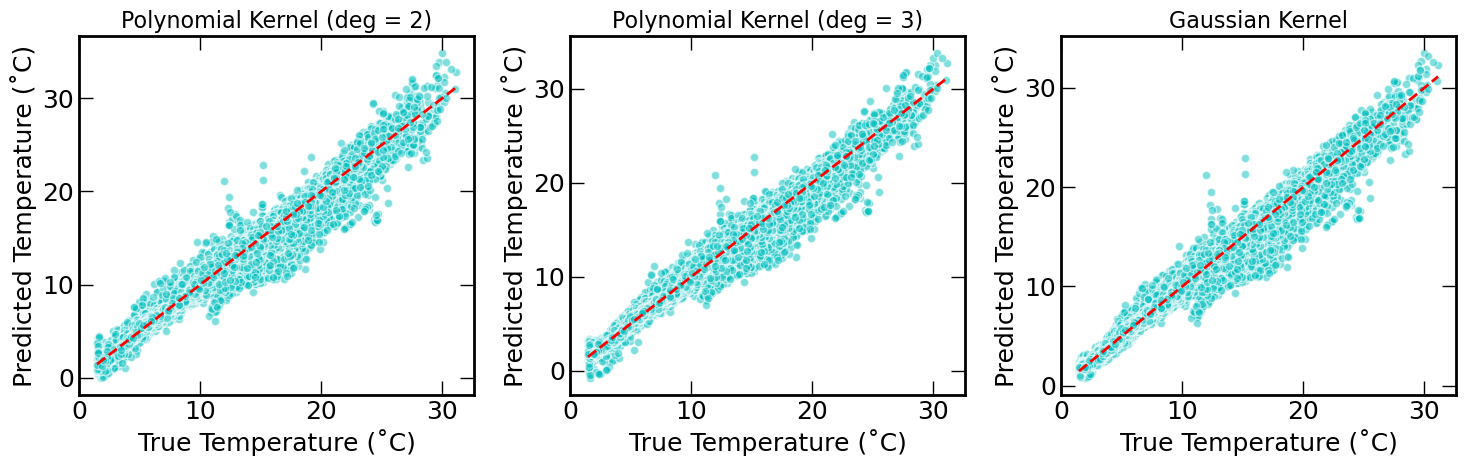

T_degC - MSE: 0.3525, R²: 0.9799
Salnty - MSE: 0.0262, R²: 0.8757


In [207]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plot_pred_vs_true(y_test_pol2[:, 0], y_pred_pol2[:, 0], label='Polynomial Kernel (deg = 2)', ax=ax[0], color = 'c')
plot_pred_vs_true(y_test_pol3[:, 0], y_pred_pol3[:, 0], label='Polynomial Kernel (deg = 3)', ax=ax[1], color = 'c')
plot_pred_vs_true(y_test_gauss[:, 0], y_pred_gauss[:, 0], label='Gaussian Kernel ', ax=ax[2], color = 'c')

ax[0].set_title('Polynomial Kernel (deg = 2)', fontsize=16)
ax[1].set_title('Polynomial Kernel (deg = 3)', fontsize=16)
ax[2].set_title('Gaussian Kernel', fontsize=16)

for a in ax:
    a.set_xlabel('True Temperature (˚C)')
    a.set_ylabel('Predicted Temperature (˚C)')

fig.tight_layout()
plt.show()


df_subset = chifis_df.sample(n=500000, random_state=42)

mse, r2, y_test, y_pred, Xtest = kernel_ridge_multitarget(
    df_subset, targets=["T_degC", "Salnty"], kernel_type="poly"
)

for t, m, r in zip(["T_degC", "Salnty"], mse, r2):
    print(f"{t} - MSE: {m:.4f}, R²: {r:.4f}")



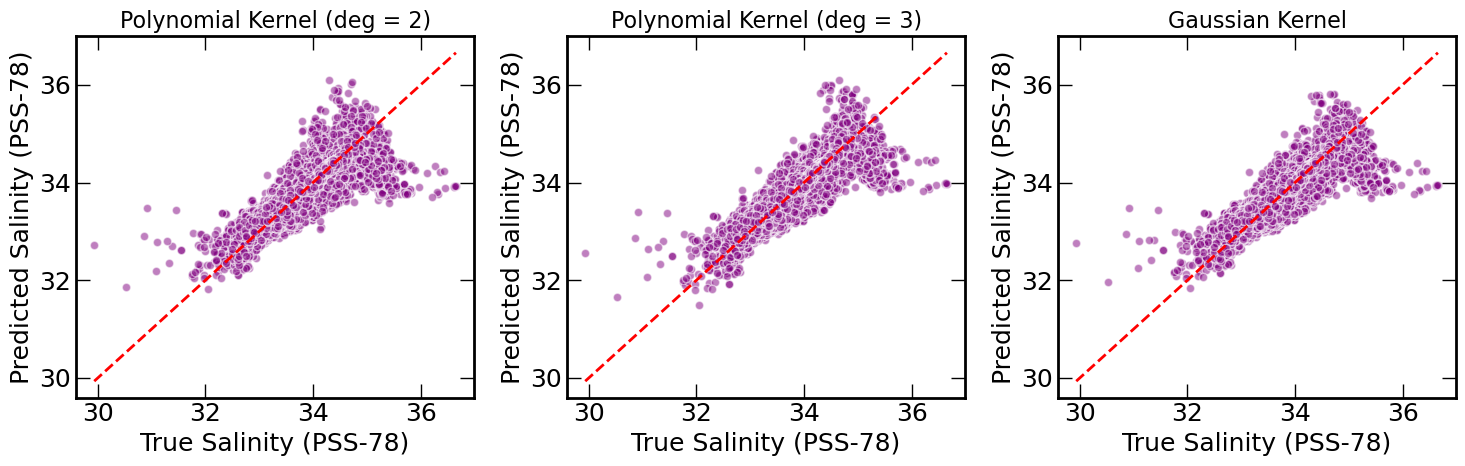

T_degC - MSE: 0.3525, R²: 0.9799
Salnty - MSE: 0.0262, R²: 0.8757


In [209]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plot_pred_vs_true(y_test_pol2[:, 1], y_pred_pol2[:, 1], label='Polynomial Kernel (deg = 2)', ax=ax[0], color = 'purple')
plot_pred_vs_true(y_test_pol3[:, 1], y_pred_pol3[:, 1], label='Polynomial Kernel (deg = 3)', ax=ax[1], color = 'purple')
plot_pred_vs_true(y_test_gauss[:, 1], y_pred_gauss[:, 1], label='Gaussian Kernel ', ax=ax[2], color = 'purple')

ax[0].set_title('Polynomial Kernel (deg = 2)', fontsize=16)
ax[1].set_title('Polynomial Kernel (deg = 3)', fontsize=16)
ax[2].set_title('Gaussian Kernel', fontsize=16)

for a in ax:
    a.set_xlabel('True Salinity (PSS-78)')
    a.set_ylabel('Predicted Salinity (PSS-78)')

fig.tight_layout()
plt.show()


df_subset = chifis_df.sample(n=500000, random_state=42)

mse, r2, y_test, y_pred, Xtest= kernel_ridge_multitarget(
    df_subset, targets=["T_degC", "Salnty"], kernel_type="poly"
)

for t, m, r in zip(["T_degC", "Salnty"], mse, r2):
    print(f"{t} - MSE: {m:.4f}, R²: {r:.4f}")



The quality of the multi target improves when using kernel methods. 

#### Temperature

In [212]:
df_subset = chifis_df.sample(n=500000, random_state=42)

mse_poly, r2_poly, y_poly, y_pred_poly, X_test_T_pol3 = kernel_ridge_regression(df_subset, target="T_degC", kernel_type="poly")
mse_poly_2, r2_poly_2, y_poly_2, y_pred_poly_2, X_test_T_pol2 = kernel_ridge_regression(df_subset, target="T_degC", kernel_type="poly", poly_degree = 2)
mse_rbf, r2_rbf, y_rbf, y_pred_rbf, X_test_T_gauss   = kernel_ridge_regression(df_subset, target="T_degC", kernel_type="rbf")

print(f"3 degree Polynomial Kernel: MSE = {mse_poly:.4f}, R² = {r2_poly:.4f}")
print(f"2 degree Polynomial Kernel: MSE = {mse_poly_2:.4f}, R² = {r2_poly_2:.4f}")
print(f"RBF Kernel:  MSE = {mse_rbf:.4f}, R² = {r2_rbf:.4f}")


3 degree Polynomial Kernel: MSE = 0.0023, R² = 0.9999
2 degree Polynomial Kernel: MSE = 0.0045, R² = 0.9997
RBF Kernel:  MSE = 0.0087, R² = 0.9995


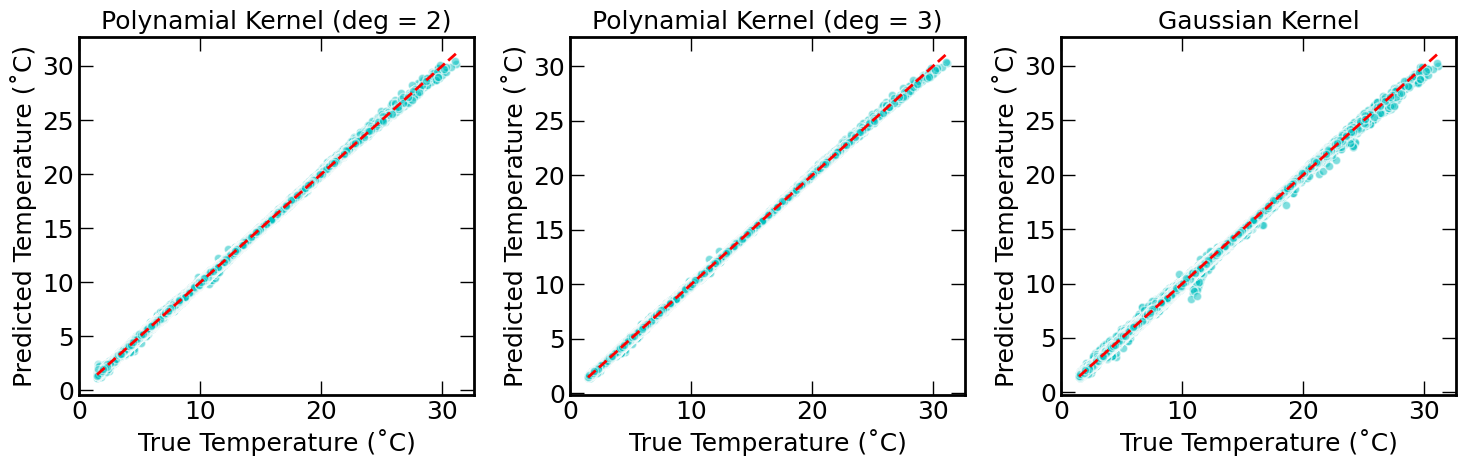

In [213]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plot_pred_vs_true(y_poly_2, y_pred_poly_2, label = 'Polynamial Kernel (deg = 2)', ax=ax[0], color = 'c')
plot_pred_vs_true(y_poly, y_pred_poly, label = 'Polynamial Kernel (deg = 3)', ax=ax[1], color = 'c')
plot_pred_vs_true(y_rbf, y_pred_rbf, label = 'Gaussian Kernel', ax=ax[2], color = 'c')
ax[0].set_title('Polynamial Kernel (deg = 2)', fontsize = 18)
ax[1].set_title('Polynamial Kernel (deg = 3)', fontsize = 18)
ax[2].set_title('Gaussian Kernel', fontsize = 18)
for a in ax:   
    a.set_xlabel('True Temperature (˚C)')
    a.set_ylabel('Predicted Temperature (˚C)')
fig.tight_layout()
plt.show()

#### Salinity

In [214]:
df_subset = chifis_df.sample(n=500000, random_state=42)

mse_poly, r2_poly, y_poly, y_pred_poly, X_test_S_pol3 = kernel_ridge_regression(df_subset, target="Salnty", kernel_type="poly")
mse_poly_2, r2_poly_2, y_poly_2, y_pred_poly_2, X_test_S_pol2 = kernel_ridge_regression(df_subset, target="Salnty", kernel_type="poly", poly_degree = 2)
mse_rbf, r2_rbf, y_rbf, y_pred_rbf, X_test_TSgauss   = kernel_ridge_regression(df_subset, target="Salnty", kernel_type="rbf")

print(f"====== Salinity kernel results ======")
print(f"=====================================")
print(f"Poly degree 3 - Kernel: MSE = {mse_poly:.4f}, R² = {r2_poly:.4f}")
print(f"Poly degree 2 - Kernel: MSE = {mse_poly_2:.4f}, R² = {r2_poly_2:.4f}")
print(f"Gaussian Kernel:  MSE = {mse_rbf:.4f}, R² = {r2_rbf:.4f}")


====== Salinity kernel results ======
Poly degree 3 - Kernel: MSE = 0.0000, R² = 0.9999
Poly degree 2 - Kernel: MSE = 0.0000, R² = 0.9998
Gaussian Kernel:  MSE = 0.0002, R² = 0.9991


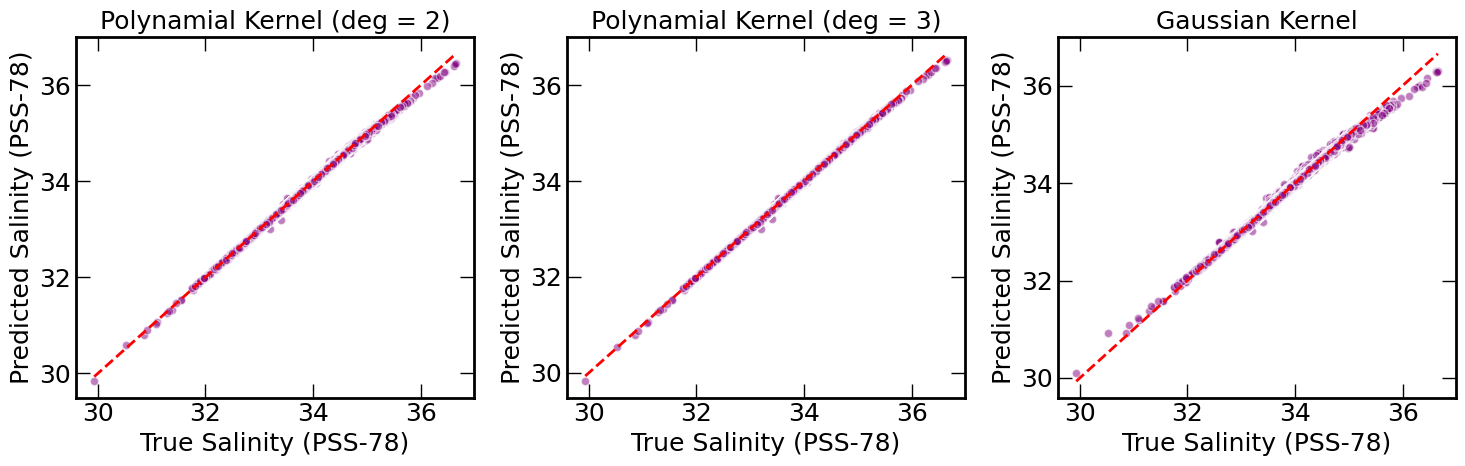

In [215]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plot_pred_vs_true(y_poly_2, y_pred_poly_2, label = 'Polynamial Kernel (deg = 2)', ax=ax[0], color = 'purple')
plot_pred_vs_true(y_poly, y_pred_poly, label = 'Polynamial Kernel (deg = 3)', ax=ax[1], color = 'purple')
plot_pred_vs_true(y_rbf, y_pred_rbf, label = 'Gaussian Kernel', ax=ax[2], color = 'purple')
ax[0].set_title('Polynamial Kernel (deg = 2)', fontsize = 18)
ax[1].set_title('Polynamial Kernel (deg = 3)', fontsize = 18)
ax[2].set_title('Gaussian Kernel', fontsize = 18)
for a in ax:   
    a.set_xlabel('True Salinity (PSS-78)')
    a.set_ylabel('Predicted Salinity (PSS-78)')
fig.tight_layout()
plt.show()

# Conclusioni

In this notebook we have introduced some of the most commonly used regression method used in literature. 
During the course of the notebook we have already pointed out that linear regression doesn not capture the full relations among the features. 
The linear regression had already given us some relatively good results, however the kernel methods allowed us to obtain close to perfect results, already using only a small fraction of the sample

The quality of the regression significanlty improve when introducing kernels. In particular it particularly improves using a polinomial kernel, both using a smaller sample to train the model and an approximation to perform the calculations. 
This is given by the fact that the features had non linear dependencies that can be taken into account using a kernel method.

Using Ridge or LASSO regression do not particularly improve the quality the fit. 

We show the coefficient results

In [225]:
# Rifare il grafico di partenza con i dati di test salinita, temperatura, densita 
T_results_list = []
for key in ['OLS', 'Ridge_T', 'Lasso_T']:
    df = T_final_results[key]['coeff'] #; df = df.to_frame() 
    T_results_list.append(df)
    
T_results_df = pd.concat(T_results_list, axis = 1)
T_results_df.columns = ['OLS', 'Ridge_T', 'Lasso_T']
T_results_df

,OLS,Ridge_T,Lasso_T
Depthm,-0.438743,-0.438752,-0.439003
Salnty,1.463184,1.463169,1.465506
STheta,-4.465832,-4.465769,-4.468931
Oxy_umol/kg,0.306837,0.306877,0.307193
Quarter,-0.006284,-0.006279,-0.006167
Lat_Dec,-0.162458,-0.162470,-0.162013
Lon_Dec,0.037269,0.037272,0.037280
Bottom_D,-0.061103,-0.061105,-0.061375
Wind_Spd,-0.005993,-0.005995,-0.005732
Intercept,10.923575,10.923575,10.923803


In [227]:
# Rifare il grafico di partenza con i dati di test salinita, temperatura, densita 
S_results_list = []
for key in ['OLS', 'Ridge_S', 'Lasso_S']:
    df = S_final_results[key]['coeff'] #; df = df.to_frame() 
    S_results_list.append(df)
    
S_results_df = pd.concat(S_results_list, axis = 1)
S_results_df.columns = ['OLS', 'Ridge_S', 'Lasso_S']
S_results_df

,OLS,Ridge_S,Lasso_S
Depthm,0.128255,0.128255,0.128239
T_degC,1.115222,1.115212,1.114923
STheta,1.187520,1.187508,1.187727
Oxy_umol/kg,-0.133504,-0.133507,-0.133362
Quarter,0.001178,0.001177,0.001164
Lat_Dec,0.021466,0.021464,0.021341
Lon_Dec,-0.014043,-0.014043,-0.013972
Bottom_D,0.005620,0.005620,0.005745
Wind_Spd,0.000701,0.000701,0.000615
Intercept,33.835330,33.835330,33.835556


In [229]:
df_OLS_multi = T_final_results['OLS_TS']['coeff']; df_OLS_multi.column = 'Temperature_T+S_OLS'
pd.concat([df_OLS_multi, TS_coeff_df['Temperature_T+S_ridge'], TS_lasso_coef_df['Temperature_T+S_lasso']], axis = 1)

,T_degC,Temperature_T+S_ridge,Temperature_T+S_lasso
Depthm,-0.200721,-0.200721,-0.200723
STheta,-4.548140,-4.548140,-4.548070
Oxy_umol/kg,-0.790012,-0.790012,-0.788181
Quarter,-0.016882,-0.016882,-0.016421
Lat_Dec,-0.627032,-0.627032,-0.627506
Lon_Dec,-0.049806,-0.049806,-0.048613
Bottom_D,-0.287941,-0.287941,-0.287558
Wind_Spd,-0.025068,-0.025068,-0.025243
Intercept,10.923575,10.923575,10.923803


In [230]:
df_OLS_multi = S_final_results['OLS_TS']['coeff']; df_OLS_multi.column = 'Salinity_T+S_OLS'
pd.concat([df_OLS_multi, TS_coeff_df['Salinity_T+S_ridge'], TS_lasso_coef_df['Salinity_T+S_lasso']], axis = 1)

,Salnty,Salinity_T+S_ridge,Salinity_T+S_lasso
Depthm,0.074707,0.074707,0.074721
STheta,-0.025834,-0.025834,-0.024826
Oxy_umol/kg,-0.344263,-0.344263,-0.343490
Quarter,-0.003326,-0.003326,-0.003212
Lat_Dec,-0.145814,-0.145814,-0.145956
Lon_Dec,-0.027330,-0.027330,-0.026927
Bottom_D,-0.071197,-0.071197,-0.070918
Wind_Spd,-0.005987,-0.005987,-0.006114
Intercept,33.835330,33.835330,33.835556


For kernel regression it is not possible to extract actual coefficients, but it possible to observe from the metrics shown and the comparison between the value of true and predicted value of the target, that it provides better results. 
This is connected with the fact that the kernel regression is able to capture and model non-linear relationships in the data. 

# Bibliografia 

- Dataset: [CalCOFI-kaggle](https://www.kaggle.com/datasets/sohier/calcofi)
- Metadati: [bottle-database](https://calcofi.org/data/oceanographic-data/bottle-database/)
- Informazioni relative alla presa dati: [sito ufficiale](https://calcofi.org/data/oceanographic-data/bottle-database/)
- Salinity scale: [salinometry](https://salinometry.com/pss-78/)
- Implementazioni: 
    - [RBFSampler](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html)
    - [temperature-salinity-geodata](https://www.kaggle.com/code/angelosorge/temperature-salinity-geodata)
    - https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#processing-the-dataset
    
